## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/solubility/solub_maccs_train.csv")
df_test = pd.read_csv("../../data/train/solubility/solub_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/solubility/solub_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'solubility']
y_train_all = df_train_all['solubility']

X_train = df_train.loc[:, df_train.columns != 'solubility']
y_train = df_train['solubility']

X_test = df_test.loc[:, df_test.columns != 'solubility']
y_test = df_test['solubility']

X_valid = df_valid.loc[:, df_valid.columns != 'solubility']
y_valid = df_valid['solubility']

In [5]:
X_train.shape

(1234, 166)

In [6]:
X_test.shape

(353, 166)

In [7]:
X_valid.shape

(176, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [8]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [9]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [10]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=176, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 4.795295550273015, Accuracy: -4.27387313923827
Test Avg. loss: 8.137664794921875, Accuracy: -9.082042183212714
################## EPOCH 2 ##################
Train Avg. loss: 2.5153482296527963, Accuracy: -1.8344947039926904
Test Avg. loss: 5.090754508972168, Accuracy: -5.307117125016741
################## EPOCH 3 ##################
Train Avg. loss: 2.336494023983295, Accuracy: -1.6482519808380363
Test Avg. loss: 5.084749698638916, Accuracy: -5.299676771577863
################## EPOCH 4 ##################
Train Avg. loss: 2.3252237882369604, Accuracy: -1.6485732015670795
Test Avg. loss: 3.0920910835266113, Accuracy: -2.83090160237635
################## EPOCH 5 ##################
Train Avg. loss: 2.5012478828430176, Accuracy: -1.8020347782368555
Test Avg. loss: 2.8056163787841797, Accuracy: -2.475977748208483
################## EPOCH 6 ##################
Train Avg. loss: 2.3256940688842382, Accu

Train Avg. loss: 1.4176663909202967, Accuracy: -0.5977807547844435
Test Avg. loss: 1.5366679430007935, Accuracy: -0.9038327011236373
################## EPOCH 48 ##################
Train Avg. loss: 1.4013188190949268, Accuracy: -0.564066765208505
Test Avg. loss: 1.0094695091247559, Accuracy: -0.2506675652287025
################## EPOCH 49 ##################
Train Avg. loss: 1.3975191085766523, Accuracy: -0.5629978572920912
Test Avg. loss: 1.083345651626587, Accuracy: -0.34219554794449447
################## EPOCH 50 ##################
Train Avg. loss: 1.5306605314597106, Accuracy: -0.7115137399804795
Test Avg. loss: 1.2278021574020386, Accuracy: -0.5211678525088475
################## EPOCH 51 ##################
Train Avg. loss: 1.4218355356118617, Accuracy: -0.6185414640974393
Test Avg. loss: 1.177432894706726, Accuracy: -0.4587635193730515
################## EPOCH 52 ##################
Train Avg. loss: 1.365523208410312, Accuracy: -0.539111634470505
Test Avg. loss: 0.9655358195304871, A

Train Avg. loss: 0.8944340355885334, Accuracy: 0.0045209064157058255
Test Avg. loss: 0.9572299718856812, Accuracy: -0.18594638332111213
################## EPOCH 94 ##################
Train Avg. loss: 0.905896130280617, Accuracy: -0.020706917357526756
Test Avg. loss: 0.9898213148117065, Accuracy: -0.22632476935827572
################## EPOCH 95 ##################
Train Avg. loss: 0.8315265774726868, Accuracy: 0.06953125697523908
Test Avg. loss: 0.9510005712509155, Accuracy: -0.17822850435315885
################## EPOCH 96 ##################
Train Avg. loss: 0.8835291472765116, Accuracy: 0.01120552716491217
Test Avg. loss: 0.9222344160079956, Accuracy: -0.14258894537345634
################## EPOCH 97 ##################
Train Avg. loss: 0.8164765108854343, Accuracy: 0.07444146331514376
Test Avg. loss: 1.1201130151748657, Accuracy: -0.38774794634285636
################## EPOCH 98 ##################
Train Avg. loss: 0.8234112751789582, Accuracy: 0.0744562062342991
Test Avg. loss: 0.95162516

Train Avg. loss: 0.5432338340160174, Accuracy: 0.38567877677783313
Test Avg. loss: 0.8775702714920044, Accuracy: -0.0872530887817442
################## EPOCH 140 ##################
Train Avg. loss: 0.5274446950508997, Accuracy: 0.4036560967999492
Test Avg. loss: 0.8726295232772827, Accuracy: -0.08113176971060687
################## EPOCH 141 ##################
Train Avg. loss: 0.5609833319217731, Accuracy: 0.37088221031400015
Test Avg. loss: 0.7850676774978638, Accuracy: 0.02735168154630796
################## EPOCH 142 ##################
Train Avg. loss: 0.5874984715229425, Accuracy: 0.3415026994869687
Test Avg. loss: 0.8225784301757812, Accuracy: -0.019121618396414686
################## EPOCH 143 ##################
Train Avg. loss: 0.576285876524754, Accuracy: 0.35519489739009363
Test Avg. loss: 0.8872642517089844, Accuracy: -0.09926327442032634
################## EPOCH 144 ##################
Train Avg. loss: 0.5350554149884444, Accuracy: 0.39610527900172654
Test Avg. loss: 0.832744181

Train Avg. loss: 0.4026858523870126, Accuracy: 0.5459300209871275
Test Avg. loss: 0.8180477023124695, Accuracy: -0.013508524380658082
################## EPOCH 186 ##################
Train Avg. loss: 0.3828381448984146, Accuracy: 0.5701264773973965
Test Avg. loss: 0.805844783782959, Accuracy: 0.0016102778791272643
################## EPOCH 187 ##################
Train Avg. loss: 0.3901533835973495, Accuracy: 0.5695036682917635
Test Avg. loss: 0.8017705082893372, Accuracy: 0.006658069349066653
################## EPOCH 188 ##################
Train Avg. loss: 0.3843471709734354, Accuracy: 0.5725893107048841
Test Avg. loss: 0.8115755915641785, Accuracy: -0.005489829938513768
################## EPOCH 189 ##################
Train Avg. loss: 0.3715068017825102, Accuracy: 0.5832479123999716
Test Avg. loss: 0.781254768371582, Accuracy: 0.032075617261190126
################## EPOCH 190 ##################
Train Avg. loss: 0.35692785107172453, Accuracy: 0.5983666147164528
Test Avg. loss: 0.804057598

Train Avg. loss: 0.3155898658128885, Accuracy: 0.6425842685730172
Test Avg. loss: 0.7563218474388123, Accuracy: 0.06296603075734131
################## EPOCH 232 ##################
Train Avg. loss: 0.2807101038021919, Accuracy: 0.6811963264756917
Test Avg. loss: 0.7847432494163513, Accuracy: 0.027753666040971847
################## EPOCH 233 ##################
Train Avg. loss: 0.2686822960774104, Accuracy: 0.6984428858593505
Test Avg. loss: 0.7884906530380249, Accuracy: 0.023110911064058937
################## EPOCH 234 ##################
Train Avg. loss: 0.2783631682395935, Accuracy: 0.6817083982478778
Test Avg. loss: 0.790830135345459, Accuracy: 0.02021245729763621
################## EPOCH 235 ##################
Train Avg. loss: 0.29292031473074204, Accuracy: 0.6708572442623438
Test Avg. loss: 0.7755689024925232, Accuracy: 0.03911998660300153
################## EPOCH 236 ##################
Train Avg. loss: 0.269580371486835, Accuracy: 0.6983297623906454
Test Avg. loss: 0.799179017543792

Train Avg. loss: 0.24624319221728888, Accuracy: 0.7242893833569846
Test Avg. loss: 0.8084056377410889, Accuracy: -0.0015625260931861895
################## EPOCH 278 ##################
Train Avg. loss: 0.2586046889042243, Accuracy: 0.7110191793599439
Test Avg. loss: 0.8243274092674255, Accuracy: -0.021288600993103035
################## EPOCH 279 ##################
Train Avg. loss: 0.24874720512292323, Accuracy: 0.7220034545556256
Test Avg. loss: 0.8034278154373169, Accuracy: 0.0046046830717718645
################## EPOCH 280 ##################
Train Avg. loss: 0.2474866203772716, Accuracy: 0.7248013607236147
Test Avg. loss: 0.7951791286468506, Accuracy: 0.014824314550764273
################## EPOCH 281 ##################
Train Avg. loss: 0.23797554083359548, Accuracy: 0.7309466721746268
Test Avg. loss: 0.79420405626297, Accuracy: 0.016032285513612243
################## EPOCH 282 ##################
Train Avg. loss: 0.2527243577134915, Accuracy: 0.7131251379787898
Test Avg. loss: 0.801419

Train Avg. loss: 1.9380369663238526, Accuracy: -1.0873652313871716
Test Avg. loss: 1.9084601402282715, Accuracy: -1.3644590822178295
################## EPOCH 26 ##################
Train Avg. loss: 1.7681720077991485, Accuracy: -0.926296713122061
Test Avg. loss: 1.6929552555084229, Accuracy: -1.0974624662221957
################## EPOCH 27 ##################
Train Avg. loss: 1.713379329442978, Accuracy: -0.849066579854308
Test Avg. loss: 2.428725004196167, Accuracy: -2.0090337770418905
################## EPOCH 28 ##################
Train Avg. loss: 1.783439838886261, Accuracy: -0.9432085226954646
Test Avg. loss: 1.8687727451324463, Accuracy: -1.3152889451210088
################## EPOCH 29 ##################
Train Avg. loss: 1.7494506299495698, Accuracy: -0.8872405052593919
Test Avg. loss: 1.3801484107971191, Accuracy: -0.709914854627337
################## EPOCH 30 ##################
Train Avg. loss: 1.8610580563545227, Accuracy: -0.9958598130778699
Test Avg. loss: 1.7257219552993774, Acc

Train Avg. loss: 1.2343387126922607, Accuracy: -0.3441534270992155
Test Avg. loss: 1.3231967687606812, Accuracy: -0.6393554500814056
################## EPOCH 73 ##################
Train Avg. loss: 1.2341144561767579, Accuracy: -0.3373733398296285
Test Avg. loss: 1.4764692783355713, Accuracy: -0.8292502670945323
################## EPOCH 74 ##################
Train Avg. loss: 1.1335989594459535, Accuracy: -0.22989155146091594
Test Avg. loss: 1.4915663003921509, Accuracy: -0.8479544491273756
################## EPOCH 75 ##################
Train Avg. loss: 1.2794692754745483, Accuracy: -0.38587390377278297
Test Avg. loss: 1.449637770652771, Accuracy: -0.7960078328846334
################## EPOCH 76 ##################
Train Avg. loss: 1.2455328673124313, Accuracy: -0.36149859365269743
Test Avg. loss: 1.3742939233779907, Accuracy: -0.7026617297986228
################## EPOCH 77 ##################
Train Avg. loss: 1.185439231991768, Accuracy: -0.3014438108665626
Test Avg. loss: 1.38448655605316

Train Avg. loss: 0.9225890606641769, Accuracy: -0.010425219765661482
Test Avg. loss: 1.286786437034607, Accuracy: -0.5942454317021315
################## EPOCH 119 ##################
Train Avg. loss: 0.9007962077856064, Accuracy: 0.01823870011987282
Test Avg. loss: 1.1776169538497925, Accuracy: -0.4589915920708132
################## EPOCH 120 ##################
Train Avg. loss: 0.9555037558078766, Accuracy: -0.03707921180930429
Test Avg. loss: 1.0481388568878174, Accuracy: -0.2985765656096879
################## EPOCH 121 ##################
Train Avg. loss: 0.9020970523357391, Accuracy: 0.02739805586312629
Test Avg. loss: 0.9935216307640076, Accuracy: -0.23090937907554965
################## EPOCH 122 ##################
Train Avg. loss: 0.9877631455659867, Accuracy: -0.07486138836066494
Test Avg. loss: 1.0602778196334839, Accuracy: -0.31361590572934217
################## EPOCH 123 ##################
Train Avg. loss: 0.9047105014324188, Accuracy: 0.014459476938648335
Test Avg. loss: 1.0175

Train Avg. loss: 0.6359900906682014, Accuracy: 0.30826484771768814
Test Avg. loss: 1.031597375869751, Accuracy: -0.2780827527868557
################## EPOCH 165 ##################
Train Avg. loss: 0.7382766872644424, Accuracy: 0.2023827438710585
Test Avg. loss: 0.9055200219154358, Accuracy: -0.12188101611545576
################## EPOCH 166 ##################
Train Avg. loss: 0.6844309940934181, Accuracy: 0.26320613323430686
Test Avg. loss: 0.9862462878227234, Accuracy: -0.22189570363380562
################## EPOCH 167 ##################
Train Avg. loss: 0.6704976692795753, Accuracy: 0.27313463391549286
Test Avg. loss: 1.0463078022003174, Accuracy: -0.2963079432974669
################## EPOCH 168 ##################
Train Avg. loss: 0.6506021946668625, Accuracy: 0.29344941923896395
Test Avg. loss: 0.9813149571418762, Accuracy: -0.2157859703939624
################## EPOCH 169 ##################
Train Avg. loss: 0.6908007144927979, Accuracy: 0.2516057881760895
Test Avg. loss: 0.89856261014

Train Avg. loss: 0.5109753623604775, Accuracy: 0.4382227139172755
Test Avg. loss: 0.8691274523735046, Accuracy: -0.07679293501580187
################## EPOCH 212 ##################
Train Avg. loss: 0.49982391223311423, Accuracy: 0.45838638318292463
Test Avg. loss: 0.8627738356590271, Accuracy: -0.06892119411870223
################## EPOCH 213 ##################
Train Avg. loss: 0.5388344898819923, Accuracy: 0.42028459426506537
Test Avg. loss: 0.8127413988113403, Accuracy: -0.006934139611348922
################## EPOCH 214 ##################
Train Avg. loss: 0.530912484228611, Accuracy: 0.4285173492903006
Test Avg. loss: 0.852461576461792, Accuracy: -0.05614492210014599
################## EPOCH 215 ##################
Train Avg. loss: 0.5036445677280426, Accuracy: 0.4535334921101205
Test Avg. loss: 0.8739628791809082, Accuracy: -0.08278372145299628
################## EPOCH 216 ##################
Train Avg. loss: 0.5172694012522697, Accuracy: 0.43559256878465574
Test Avg. loss: 0.82434630

Train Avg. loss: 0.3898424006998539, Accuracy: 0.5727586368043471
Test Avg. loss: 0.8361175060272217, Accuracy: -0.03589573800867152
################## EPOCH 258 ##################
Train Avg. loss: 0.3877932086586952, Accuracy: 0.5789390655811836
Test Avg. loss: 0.8642041087150574, Accuracy: -0.07069328142705156
################## EPOCH 259 ##################
Train Avg. loss: 0.39576055109500885, Accuracy: 0.57007134471099
Test Avg. loss: 0.7868559956550598, Accuracy: 0.025136121630225494
################## EPOCH 260 ##################
Train Avg. loss: 0.4215908728539944, Accuracy: 0.543264659689217
Test Avg. loss: 0.7952771782875061, Accuracy: 0.01470280924999201
################## EPOCH 261 ##################
Train Avg. loss: 0.3930782854557037, Accuracy: 0.5733508591026089
Test Avg. loss: 0.8016438484191895, Accuracy: 0.006814942495606324
################## EPOCH 262 ##################
Train Avg. loss: 0.4130858317017555, Accuracy: 0.552876736463929
Test Avg. loss: 0.867969214916229

Train Avg. loss: 2.1300867438316344, Accuracy: -1.247734566785375
Test Avg. loss: 4.8856916427612305, Accuracy: -5.053056921681359
################## EPOCH 6 ##################
Train Avg. loss: 2.0892087697982786, Accuracy: -1.2046584282500876
Test Avg. loss: 3.141397714614868, Accuracy: -2.891989066960373
################## EPOCH 7 ##################
Train Avg. loss: 1.964834499359131, Accuracy: -1.0634166139173604
Test Avg. loss: 3.2082929611206055, Accuracy: -2.9748683322404954
################## EPOCH 8 ##################
Train Avg. loss: 1.9569414854049683, Accuracy: -1.0652031682834058
Test Avg. loss: 3.4970431327819824, Accuracy: -3.332610981008634
################## EPOCH 9 ##################
Train Avg. loss: 1.8853451013565063, Accuracy: -0.9990716515431366
Test Avg. loss: 3.0333309173583984, Accuracy: -2.7581015206706807
################## EPOCH 10 ##################
Train Avg. loss: 1.833906078338623, Accuracy: -0.9367196872755272
Test Avg. loss: 2.481623888015747, Accuracy:

Train Avg. loss: 1.5573026657104492, Accuracy: -0.6435756124888907
Test Avg. loss: 3.159740924835205, Accuracy: -2.9147157049445744
################## EPOCH 52 ##################
Train Avg. loss: 1.5913621544837953, Accuracy: -0.6807019442579099
Test Avg. loss: 3.155975103378296, Accuracy: -2.910049824040861
################## EPOCH 53 ##################
Train Avg. loss: 1.5320200443267822, Accuracy: -0.6240380887378892
Test Avg. loss: 3.054521083831787, Accuracy: -2.784354910017168
################## EPOCH 54 ##################
Train Avg. loss: 1.5531098008155824, Accuracy: -0.638931696516653
Test Avg. loss: 2.6508281230926514, Accuracy: -2.2842053357651757
################## EPOCH 55 ##################
Train Avg. loss: 1.5450034379959106, Accuracy: -0.6254337776897578
Test Avg. loss: 2.186645984649658, Accuracy: -1.7091137818178943
################## EPOCH 56 ##################
Train Avg. loss: 1.4600428938865662, Accuracy: -0.5353980817962642
Test Avg. loss: 2.72796368598938, Accura

Train Avg. loss: 1.251411998271942, Accuracy: -0.32137698835814765
Test Avg. loss: 1.828198790550232, Accuracy: -1.2650206112921936
################## EPOCH 99 ##################
Train Avg. loss: 1.3345192313194274, Accuracy: -0.4107560199574222
Test Avg. loss: 2.0017473697662354, Accuracy: -1.48003602747719
################## EPOCH 100 ##################
Train Avg. loss: 1.2184517800807952, Accuracy: -0.2863547089539174
Test Avg. loss: 1.6770224571228027, Accuracy: -1.077722843908071
################## EPOCH 101 ##################
Train Avg. loss: 1.2693289816379547, Accuracy: -0.3469364453168583
Test Avg. loss: 1.9726980924606323, Accuracy: -1.4440458829108116
################## EPOCH 102 ##################
Train Avg. loss: 1.377840256690979, Accuracy: -0.45338091883589876
Test Avg. loss: 2.035987138748169, Accuracy: -1.52245695535436
################## EPOCH 103 ##################
Train Avg. loss: 1.3484359860420227, Accuracy: -0.42102210298753506
Test Avg. loss: 1.6216959953308105,

Train Avg. loss: 1.08545081615448, Accuracy: -0.14693294733649168
Test Avg. loss: 1.5107760429382324, Accuracy: -0.8717541056653173
################## EPOCH 148 ##################
Train Avg. loss: 1.0669982194900514, Accuracy: -0.12163128861673467
Test Avg. loss: 1.44330894947052, Accuracy: -0.7881668231457435
################## EPOCH 149 ##################
Train Avg. loss: 1.0999357938766479, Accuracy: -0.1619114497830712
Test Avg. loss: 1.4940767288208008, Accuracy: -0.8510648069137743
################## EPOCH 150 ##################
Train Avg. loss: 1.0423358082771301, Accuracy: -0.09935692649284955
Test Avg. loss: 1.5104974508285522, Accuracy: -0.8714091335551581
################## EPOCH 151 ##################
Train Avg. loss: 1.1213146090507506, Accuracy: -0.18194394848710052
Test Avg. loss: 1.361863136291504, Accuracy: -0.6872607178624419
################## EPOCH 152 ##################
Train Avg. loss: 1.14540776014328, Accuracy: -0.20993393348689401
Test Avg. loss: 1.857565283775

Train Avg. loss: 0.8815309345722199, Accuracy: 0.06953725479375276
Test Avg. loss: 1.2448310852050781, Accuracy: -0.5422654427260378
################## EPOCH 196 ##################
Train Avg. loss: 0.9150389611721039, Accuracy: 0.03625642027616677
Test Avg. loss: 1.320626139640808, Accuracy: -0.6361706959057556
################## EPOCH 197 ##################
Train Avg. loss: 0.8888189256191253, Accuracy: 0.06025759180361512
Test Avg. loss: 1.1480634212493896, Accuracy: -0.42237657077782975
################## EPOCH 198 ##################
Train Avg. loss: 0.9019395530223846, Accuracy: 0.05070921385612208
Test Avg. loss: 1.213517189025879, Accuracy: -0.5034695241202236
################## EPOCH 199 ##################
Train Avg. loss: 0.9990083575248718, Accuracy: -0.057679739570512534
Test Avg. loss: 1.4692376852035522, Accuracy: -0.8202908754175364
################## EPOCH 200 ##################
Train Avg. loss: 0.8741406798362732, Accuracy: 0.07521172680865727
Test Avg. loss: 1.473373413

Train Avg. loss: 0.7937009930610657, Accuracy: 0.16294699145185537
Test Avg. loss: 1.1813726425170898, Accuracy: -0.4636444275289544
################## EPOCH 243 ##################
Train Avg. loss: 0.8262427508831024, Accuracy: 0.12834330435253033
Test Avg. loss: 1.3449053764343262, Accuracy: -0.6662512048812013
################## EPOCH 244 ##################
Train Avg. loss: 0.7775089681148529, Accuracy: 0.18156191698023413
Test Avg. loss: 1.2969287633895874, Accuracy: -0.6068112499336429
################## EPOCH 245 ##################
Train Avg. loss: 0.8045126497745514, Accuracy: 0.1471418310656583
Test Avg. loss: 1.1414859294891357, Accuracy: -0.41422763439688937
################## EPOCH 246 ##################
Train Avg. loss: 0.7369854748249054, Accuracy: 0.2213711184543145
Test Avg. loss: 1.1265069246292114, Accuracy: -0.3956695683661029
################## EPOCH 247 ##################
Train Avg. loss: 0.7631354093551636, Accuracy: 0.1905774875023385
Test Avg. loss: 1.129371881484

Train Avg. loss: 0.6297691375017166, Accuracy: 0.3345785723751031
Test Avg. loss: 1.206804633140564, Accuracy: -0.4951531896804242
################## EPOCH 289 ##################
Train Avg. loss: 0.6926023125648498, Accuracy: 0.26993971986727894
Test Avg. loss: 1.1057482957839966, Accuracy: -0.3699509030552348
################## EPOCH 290 ##################
Train Avg. loss: 0.6298306047916412, Accuracy: 0.3335364823699207
Test Avg. loss: 0.9982226490974426, Accuracy: -0.2367335335061116
################## EPOCH 291 ##################
Train Avg. loss: 0.607670682668686, Accuracy: 0.3551794373552884
Test Avg. loss: 1.0722739696502686, Accuracy: -0.32847841673325684
################## EPOCH 292 ##################
Train Avg. loss: 0.6148206472396851, Accuracy: 0.3482768642247621
Test Avg. loss: 1.211313247680664, Accuracy: -0.5007391798446088
################## EPOCH 293 ##################
Train Avg. loss: 0.659173583984375, Accuracy: 0.3046034794190387
Test Avg. loss: 1.0658241510391235, 

Train Avg. loss: 1.5112237930297852, Accuracy: -0.583589687753461
Test Avg. loss: 3.704751491546631, Accuracy: -3.5899486639834732
################## EPOCH 39 ##################
Train Avg. loss: 1.4853896379470826, Accuracy: -0.5578253381021561
Test Avg. loss: 3.75780987739563, Accuracy: -3.655684545615693
################## EPOCH 40 ##################
Train Avg. loss: 1.402817964553833, Accuracy: -0.472316089024533
Test Avg. loss: 3.1980831623077393, Accuracy: -2.962218733592828
################## EPOCH 41 ##################
Train Avg. loss: 1.4740761041641235, Accuracy: -0.5462050815179766
Test Avg. loss: 3.062643051147461, Accuracy: -2.7944172204701285
################## EPOCH 42 ##################
Train Avg. loss: 1.4768329381942749, Accuracy: -0.5501324534106947
Test Avg. loss: 2.4067161083221436, Accuracy: -1.9817664162254274
################## EPOCH 43 ##################
Train Avg. loss: 1.4985007047653198, Accuracy: -0.5763493837890584
Test Avg. loss: 3.310129404067993, Accurac

Train Avg. loss: 1.3346152305603027, Accuracy: -0.40199661947144927
Test Avg. loss: 2.5585498809814453, Accuracy: -2.1698781801775455
################## EPOCH 85 ##################
Train Avg. loss: 1.333200168609619, Accuracy: -0.3950913648522964
Test Avg. loss: 2.394514322280884, Accuracy: -1.9666489802549236
################## EPOCH 86 ##################
Train Avg. loss: 1.3186910152435303, Accuracy: -0.3820808891177697
Test Avg. loss: 2.3917858600616455, Accuracy: -1.963268892596536
################## EPOCH 87 ##################
Train Avg. loss: 1.290002131462097, Accuracy: -0.3528231863690865
Test Avg. loss: 3.083871841430664, Accuracy: -2.8207187683479042
################## EPOCH 88 ##################
Train Avg. loss: 1.280894923210144, Accuracy: -0.34216836623838975
Test Avg. loss: 2.872767448425293, Accuracy: -2.5591736294745053
################## EPOCH 89 ##################
Train Avg. loss: 1.2872480154037476, Accuracy: -0.3537618975060178
Test Avg. loss: 2.7836477756500244, Ac

Train Avg. loss: 1.1516172885894775, Accuracy: -0.2067291798175456
Test Avg. loss: 2.2171826362609863, Accuracy: -1.7469465255642231
################## EPOCH 136 ##################
Train Avg. loss: 1.1292008876800537, Accuracy: -0.18821009482947498
Test Avg. loss: 2.2696571350097656, Accuracy: -1.811959053185499
################## EPOCH 137 ##################
Train Avg. loss: 1.156119155883789, Accuracy: -0.21343919502731484
Test Avg. loss: 2.406637668609619, Accuracy: -1.9816690037461973
################## EPOCH 138 ##################
Train Avg. loss: 1.199631643295288, Accuracy: -0.2588664732137504
Test Avg. loss: 2.4699738025665283, Accuracy: -2.060138477384924
################## EPOCH 139 ##################
Train Avg. loss: 1.197599506378174, Accuracy: -0.2569573378286827
Test Avg. loss: 2.6545562744140625, Accuracy: -2.28882401209127
################## EPOCH 140 ##################
Train Avg. loss: 1.1153825044631958, Accuracy: -0.17018272009886556
Test Avg. loss: 2.245252847671509

Train Avg. loss: 1.0729403734207152, Accuracy: -0.12332577685075093
Test Avg. loss: 1.7288808822631836, Accuracy: -1.1419721396394245
################## EPOCH 183 ##################
Train Avg. loss: 1.0269318342208862, Accuracy: -0.07567842287034751
Test Avg. loss: 2.135716199874878, Accuracy: -1.6460147916010448
################## EPOCH 184 ##################
Train Avg. loss: 1.0371232151985168, Accuracy: -0.08917442734609218
Test Avg. loss: 2.23040509223938, Accuracy: -1.7633281517679862
################## EPOCH 185 ##################
Train Avg. loss: 1.073550021648407, Accuracy: -0.1277684030078477
Test Avg. loss: 2.441204071044922, Accuracy: -2.0244946848819643
################## EPOCH 186 ##################
Train Avg. loss: 1.0665833950042725, Accuracy: -0.11680864930306027
Test Avg. loss: 2.1348519325256348, Accuracy: -1.64494399053445
################## EPOCH 187 ##################
Train Avg. loss: 1.0219121098518371, Accuracy: -0.07187463248506261
Test Avg. loss: 2.067081451416

Train Avg. loss: 0.9286329030990601, Accuracy: 0.02429800609525561
Test Avg. loss: 1.9700257778167725, Accuracy: -1.4407349496068909
################## EPOCH 231 ##################
Train Avg. loss: 0.9237956166267395, Accuracy: 0.027600196925916885
Test Avg. loss: 1.844379186630249, Accuracy: -1.2850669739107734
################## EPOCH 232 ##################
Train Avg. loss: 0.911852765083313, Accuracy: 0.04230968882586672
Test Avg. loss: 1.6917922496795654, Accuracy: -1.0960216898450166
################## EPOCH 233 ##################
Train Avg. loss: 0.9035719156265258, Accuracy: 0.05154728291425899
Test Avg. loss: 1.6906471252441406, Accuracy: -1.094603142641399
################## EPOCH 234 ##################
Train Avg. loss: 0.9391929864883423, Accuracy: 0.015258825654064178
Test Avg. loss: 1.535683035850525, Accuracy: -0.9026124899013346
################## EPOCH 235 ##################
Train Avg. loss: 0.9152390599250794, Accuracy: 0.03949222931449052
Test Avg. loss: 1.622352004051

Train Avg. loss: 0.7849608898162842, Accuracy: 0.17629439479365713
Test Avg. loss: 1.6294288635253906, Accuracy: -1.0187572870044206
################## EPOCH 277 ##################
Train Avg. loss: 0.819560706615448, Accuracy: 0.1421185090405107
Test Avg. loss: 1.5762478113174438, Accuracy: -0.9528695984409639
################## EPOCH 278 ##################
Train Avg. loss: 0.8853240728378295, Accuracy: 0.069255698292532
Test Avg. loss: 1.7230920791625977, Accuracy: -1.1348000276068841
################## EPOCH 279 ##################
Train Avg. loss: 0.8663023471832275, Accuracy: 0.09112996329135255
Test Avg. loss: 1.5475149154663086, Accuracy: -0.9172712810202706
################## EPOCH 280 ##################
Train Avg. loss: 0.8736697673797608, Accuracy: 0.08541327889258606
Test Avg. loss: 1.5085387229919434, Accuracy: -0.8689821681040693
################## EPOCH 281 ##################
Train Avg. loss: 0.8445272564888, Accuracy: 0.1155228258617953
Test Avg. loss: 1.4734961986541748, 

Train Avg. loss: 1.3217597298133068, Accuracy: -0.47832974276415907
Test Avg. loss: 0.8587897419929504, Accuracy: -0.06398514785098053
################## EPOCH 23 ##################
Train Avg. loss: 1.3509199038530006, Accuracy: -0.4868301299243163
Test Avg. loss: 0.9881638884544373, Accuracy: -0.22427133638057528
################## EPOCH 24 ##################
Train Avg. loss: 1.3693574896225562, Accuracy: -0.5184093030253459
Test Avg. loss: 0.8618507385253906, Accuracy: -0.06777763605385556
################## EPOCH 25 ##################
Train Avg. loss: 1.2532922365726569, Accuracy: -0.38706262054977264
Test Avg. loss: 0.854365348815918, Accuracy: -0.05850369357539531
################## EPOCH 26 ##################
Train Avg. loss: 1.2508348700327752, Accuracy: -0.3965195463074133
Test Avg. loss: 0.8138985633850098, Accuracy: -0.008367917004025394
################## EPOCH 27 ##################
Train Avg. loss: 1.1912688536521716, Accuracy: -0.3290653585405745
Test Avg. loss: 0.85179126

Test Avg. loss: 0.7833444476127625, Accuracy: 0.029486685833282067
################## EPOCH 69 ##################
Train Avg. loss: 0.5680633378334534, Accuracy: 0.37212118580897674
Test Avg. loss: 0.7141930460929871, Accuracy: 0.11516092779157827
################## EPOCH 70 ##################
Train Avg. loss: 0.5649828330064431, Accuracy: 0.3732627437960648
Test Avg. loss: 0.7107815742492676, Accuracy: 0.11938734734332934
################## EPOCH 71 ##################
Train Avg. loss: 0.5503213432354804, Accuracy: 0.39267595184155
Test Avg. loss: 0.7297672033309937, Accuracy: 0.09586549419645096
################## EPOCH 72 ##################
Train Avg. loss: 0.5284397281133212, Accuracy: 0.40998644651479754
Test Avg. loss: 0.7064048647880554, Accuracy: 0.12480994531374423
################## EPOCH 73 ##################
Train Avg. loss: 0.546237071355184, Accuracy: 0.3957522282876479
Test Avg. loss: 0.6959181427955627, Accuracy: 0.1378022652816141
################## EPOCH 74 ############

Train Avg. loss: 0.45370264771657115, Accuracy: 0.4934855564945761
Test Avg. loss: 0.7419734001159668, Accuracy: 0.08074282276261535
################## EPOCH 115 ##################
Train Avg. loss: 0.4513226778079302, Accuracy: 0.501384975652899
Test Avg. loss: 0.7616389989852905, Accuracy: 0.05637831451830744
################## EPOCH 116 ##################
Train Avg. loss: 0.4616157068656041, Accuracy: 0.48852119124727095
Test Avg. loss: 0.7666327953338623, Accuracy: 0.050191403500795206
################## EPOCH 117 ##################
Train Avg. loss: 0.46716243487138015, Accuracy: 0.4787256642538081
Test Avg. loss: 0.7645328044891357, Accuracy: 0.052793085224935754
################## EPOCH 118 ##################
Train Avg. loss: 0.4630588400058257, Accuracy: 0.4830999072796655
Test Avg. loss: 0.7782878875732422, Accuracy: 0.035751372208533194
################## EPOCH 119 ##################
Train Avg. loss: 0.49591144690146816, Accuracy: 0.44854066757462946
Test Avg. loss: 0.749319076

Train Avg. loss: 0.45372978693399674, Accuracy: 0.4927129525489548
Test Avg. loss: 0.7482520341873169, Accuracy: 0.07296393050671879
################## EPOCH 161 ##################
Train Avg. loss: 0.47962216306955385, Accuracy: 0.4611229987708374
Test Avg. loss: 0.7788072228431702, Accuracy: 0.03510790465939728
################## EPOCH 162 ##################
Train Avg. loss: 0.4416687106474852, Accuracy: 0.506651266269402
Test Avg. loss: 0.7666680216789246, Accuracy: 0.05014773300189246
################## EPOCH 163 ##################
Train Avg. loss: 0.44655178525508976, Accuracy: 0.4978836017664692
Test Avg. loss: 0.7296251058578491, Accuracy: 0.09604148787177136
################## EPOCH 164 ##################
Train Avg. loss: 0.4264502708728497, Accuracy: 0.525787397357689
Test Avg. loss: 0.7428374290466309, Accuracy: 0.07967233849542754
################## EPOCH 165 ##################
Train Avg. loss: 0.4616199254225462, Accuracy: 0.4858282895272916
Test Avg. loss: 0.791712284088134

Train Avg. loss: 0.485366437297601, Accuracy: 0.4605614641075702
Test Avg. loss: 0.7458339333534241, Accuracy: 0.07595981003505747
################## EPOCH 207 ##################
Train Avg. loss: 0.45728856860063016, Accuracy: 0.4897308248175426
Test Avg. loss: 0.7813531756401062, Accuracy: 0.0319537370763443
################## EPOCH 208 ##################
Train Avg. loss: 0.4413737253500865, Accuracy: 0.5068919539055419
Test Avg. loss: 0.7483747005462646, Accuracy: 0.07281194169286287
################## EPOCH 209 ##################
Train Avg. loss: 0.4501143090235881, Accuracy: 0.49898808560210084
Test Avg. loss: 0.7447984218597412, Accuracy: 0.07724268358582642
################## EPOCH 210 ##################
Train Avg. loss: 0.4542884314671541, Accuracy: 0.49813192723488814
Test Avg. loss: 0.7554213404655457, Accuracy: 0.06408164496701951
################## EPOCH 211 ##################
Train Avg. loss: 0.4469246421104822, Accuracy: 0.5052117357543376
Test Avg. loss: 0.748102962970733

Train Avg. loss: 0.41278909605283004, Accuracy: 0.5483492820587537
Test Avg. loss: 0.7434302568435669, Accuracy: 0.07893787055124335
################## EPOCH 253 ##################
Train Avg. loss: 0.414935630101424, Accuracy: 0.5361529344935414
Test Avg. loss: 0.7641268968582153, Accuracy: 0.05329603212865097
################## EPOCH 254 ##################
Train Avg. loss: 0.44068393187645155, Accuracy: 0.5119594811383643
Test Avg. loss: 0.7689623832702637, Accuracy: 0.047305179951530385
################## EPOCH 255 ##################
Train Avg. loss: 0.47195096008288556, Accuracy: 0.4715629998652453
Test Avg. loss: 0.7830535173416138, Accuracy: 0.029847177473495634
################## EPOCH 256 ##################
Train Avg. loss: 0.4470626704203777, Accuracy: 0.500589958870197
Test Avg. loss: 0.7377338409423828, Accuracy: 0.08599530075864437
################## EPOCH 257 ##################
Train Avg. loss: 0.44020647498277515, Accuracy: 0.5093991713368505
Test Avg. loss: 0.780392408370

Train Avg. loss: 0.3874923968926454, Accuracy: 0.5699522610331693
Test Avg. loss: 0.7697241902351379, Accuracy: 0.046361320390619354
################## EPOCH 299 ##################
Train Avg. loss: 0.3788160498325641, Accuracy: 0.5799259286125971
Test Avg. loss: 0.7438838481903076, Accuracy: 0.07837580504934405
################## EPOCH 300 ##################
Train Avg. loss: 0.35545048614343006, Accuracy: 0.6026794114672605
Test Avg. loss: 0.7493943572044373, Accuracy: 0.07154861044614491
Model: lr 0.005, batch_size 64
################## EPOCH 1 ##################
Train Avg. loss: 7.820840585231781, Accuracy: -7.365761635538244
Test Avg. loss: 10.807658195495605, Accuracy: -12.389991697955582
################## EPOCH 2 ##################
Train Avg. loss: 3.5340062022209167, Accuracy: -2.805717070914789
Test Avg. loss: 2.96368145942688, Accuracy: -2.6718104049418896
################## EPOCH 3 ##################
Train Avg. loss: 2.452405446767807, Accuracy: -1.6453508594747057
Test Avg. 

Train Avg. loss: 1.1538193672895432, Accuracy: -0.2526261778227327
Test Avg. loss: 0.9520468711853027, Accuracy: -0.17952475656572497
################## EPOCH 45 ##################
Train Avg. loss: 1.0995044350624084, Accuracy: -0.1931771649447327
Test Avg. loss: 1.0547960996627808, Accuracy: -0.30682440857304316
################## EPOCH 46 ##################
Train Avg. loss: 1.0221226215362549, Accuracy: -0.10867417525525853
Test Avg. loss: 0.8299575448036194, Accuracy: -0.02826398287604559
################## EPOCH 47 ##################
Train Avg. loss: 1.02307069003582, Accuracy: -0.11077322438123871
Test Avg. loss: 0.9842721819877625, Accuracy: -0.21944991118557033
################## EPOCH 48 ##################
Train Avg. loss: 1.009883913397789, Accuracy: -0.09295776969582241
Test Avg. loss: 0.9062730669975281, Accuracy: -0.12281399413639793
################## EPOCH 49 ##################
Train Avg. loss: 1.0358296424150466, Accuracy: -0.11037209009275525
Test Avg. loss: 0.938513755

Train Avg. loss: 0.5591064974665642, Accuracy: 0.39130220816090333
Test Avg. loss: 0.7277120351791382, Accuracy: 0.09841162019175709
################## EPOCH 91 ##################
Train Avg. loss: 0.5641187831759453, Accuracy: 0.3848982813225182
Test Avg. loss: 0.7671944499015808, Accuracy: 0.04949549681774945
################## EPOCH 92 ##################
Train Avg. loss: 0.5644153311848641, Accuracy: 0.3891076769430314
Test Avg. loss: 0.7158393859863281, Accuracy: 0.11312108519070041
################## EPOCH 93 ##################
Train Avg. loss: 0.5441986382007599, Accuracy: 0.410307132587256
Test Avg. loss: 0.7903026342391968, Accuracy: 0.02086597820353797
################## EPOCH 94 ##################
Train Avg. loss: 0.5064662799239159, Accuracy: 0.4482290139396059
Test Avg. loss: 0.7385907173156738, Accuracy: 0.08493375156627736
################## EPOCH 95 ##################
Train Avg. loss: 0.5155399188399314, Accuracy: 0.4424784405604004
Test Avg. loss: 0.7763373851776123, Acc

Train Avg. loss: 0.46246701329946516, Accuracy: 0.49858588098676754
Test Avg. loss: 0.8033100962638855, Accuracy: 0.004750566669333156
################## EPOCH 138 ##################
Train Avg. loss: 0.43173329830169677, Accuracy: 0.5315233116143901
Test Avg. loss: 0.7382106781005859, Accuracy: 0.08540449581741016
################## EPOCH 139 ##################
Train Avg. loss: 0.41404391825199127, Accuracy: 0.5517467404435831
Test Avg. loss: 0.7472885251045227, Accuracy: 0.07415762526488845
################## EPOCH 140 ##################
Train Avg. loss: 0.38598050028085706, Accuracy: 0.5816796437580014
Test Avg. loss: 0.744003415107727, Accuracy: 0.07822774435543
################## EPOCH 141 ##################
Train Avg. loss: 0.398596615344286, Accuracy: 0.5670270713672565
Test Avg. loss: 0.7804974913597107, Accuracy: 0.03301400012219835
################## EPOCH 142 ##################
Train Avg. loss: 0.3884321555495262, Accuracy: 0.5781563185217056
Test Avg. loss: 0.802584946155548

Train Avg. loss: 0.3351234503090382, Accuracy: 0.6349452972783974
Test Avg. loss: 0.8265969753265381, Accuracy: -0.02410042503806986
################## EPOCH 184 ##################
Train Avg. loss: 0.33441162034869193, Accuracy: 0.6373127336636364
Test Avg. loss: 0.8603423237800598, Accuracy: -0.06590872913330359
################## EPOCH 185 ##################
Train Avg. loss: 0.3668522238731384, Accuracy: 0.6021173384261636
Test Avg. loss: 0.8668159246444702, Accuracy: -0.07392916682409534
################## EPOCH 186 ##################
Train Avg. loss: 0.36053549945354463, Accuracy: 0.61062939677454
Test Avg. loss: 0.8032116889953613, Accuracy: 0.0048724776457688135
################## EPOCH 187 ##################
Train Avg. loss: 0.32380492985248566, Accuracy: 0.6482675872244941
Test Avg. loss: 0.7554031014442444, Accuracy: 0.06410423838405843
################## EPOCH 188 ##################
Train Avg. loss: 0.35163864940404893, Accuracy: 0.6193450554157499
Test Avg. loss: 0.799498856

Train Avg. loss: 0.34257810190320015, Accuracy: 0.6278363094834066
Test Avg. loss: 0.7861015200614929, Accuracy: 0.026070814807460208
################## EPOCH 230 ##################
Train Avg. loss: 0.3527631998062134, Accuracy: 0.6167152679948888
Test Avg. loss: 0.7958592772483826, Accuracy: 0.013981667335568937
################## EPOCH 231 ##################
Train Avg. loss: 0.32123599722981455, Accuracy: 0.650559400248299
Test Avg. loss: 0.8195008635520935, Accuracy: -0.015308740572192114
################## EPOCH 232 ##################
Train Avg. loss: 0.3380481019616127, Accuracy: 0.6299714376682175
Test Avg. loss: 0.779389500617981, Accuracy: 0.03438665207852498
################## EPOCH 233 ##################
Train Avg. loss: 0.340850580483675, Accuracy: 0.6322389210184722
Test Avg. loss: 0.8023654222488403, Accuracy: 0.005920922611006851
################## EPOCH 234 ##################
Train Avg. loss: 0.3496470056474209, Accuracy: 0.6194794540802526
Test Avg. loss: 0.781048178672

Train Avg. loss: 0.3220366410911083, Accuracy: 0.6546408947275941
Test Avg. loss: 0.8194783329963684, Accuracy: -0.015280930572588503
################## EPOCH 276 ##################
Train Avg. loss: 0.29211573824286463, Accuracy: 0.6835455603894905
Test Avg. loss: 0.7803474068641663, Accuracy: 0.03319983096669066
################## EPOCH 277 ##################
Train Avg. loss: 0.284532617777586, Accuracy: 0.6909305323184718
Test Avg. loss: 0.8653632402420044, Accuracy: -0.07212942521175925
################## EPOCH 278 ##################
Train Avg. loss: 0.27410459741950033, Accuracy: 0.7018845560316129
Test Avg. loss: 0.8026767373085022, Accuracy: 0.005535225004111077
################## EPOCH 279 ##################
Train Avg. loss: 0.29688664749264715, Accuracy: 0.6778963924029076
Test Avg. loss: 0.8246039748191833, Accuracy: -0.02163121947619473
################## EPOCH 280 ##################
Train Avg. loss: 0.27253684103488923, Accuracy: 0.7066398173308611
Test Avg. loss: 0.81629043

Train Avg. loss: 2.102979362010956, Accuracy: -1.2233446125721088
Test Avg. loss: 1.088658332824707, Accuracy: -0.3487774542265567
################## EPOCH 22 ##################
Train Avg. loss: 1.8702889680862427, Accuracy: -0.9679016777658521
Test Avg. loss: 1.048413872718811, Accuracy: -0.29891721614479216
################## EPOCH 23 ##################
Train Avg. loss: 1.8769901394844055, Accuracy: -0.9828513879634306
Test Avg. loss: 1.089280366897583, Accuracy: -0.34954820018247634
################## EPOCH 24 ##################
Train Avg. loss: 1.909045684337616, Accuracy: -1.0149053736952447
Test Avg. loss: 1.1516669988632202, Accuracy: -0.4268412094266476
################## EPOCH 25 ##################
Train Avg. loss: 1.9833013534545898, Accuracy: -1.0900976664143622
Test Avg. loss: 1.0137277841567993, Accuracy: -0.25594347476017343
################## EPOCH 26 ##################
Train Avg. loss: 1.8986280679702758, Accuracy: -1.003398887868835
Test Avg. loss: 1.0628283023834229, 

Train Avg. loss: 1.297713029384613, Accuracy: -0.3701791529387151
Test Avg. loss: 0.8730834722518921, Accuracy: -0.08169430772240927
################## EPOCH 68 ##################
Train Avg. loss: 1.2619844675064087, Accuracy: -0.33844019403459613
Test Avg. loss: 0.9193090200424194, Accuracy: -0.1389646943875824
################## EPOCH 69 ##################
Train Avg. loss: 1.2058675825595855, Accuracy: -0.2727550699806
Test Avg. loss: 0.922691285610199, Accuracy: -0.1431550706214535
################## EPOCH 70 ##################
Train Avg. loss: 1.1688223421573638, Accuracy: -0.22924536702972817
Test Avg. loss: 1.0339778661727905, Accuracy: -0.2810320783295872
################## EPOCH 71 ##################
Train Avg. loss: 1.188947582244873, Accuracy: -0.2544408019745582
Test Avg. loss: 1.0252035856246948, Accuracy: -0.2701612238480131
################## EPOCH 72 ##################
Train Avg. loss: 1.076157569885254, Accuracy: -0.13415400008959455
Test Avg. loss: 0.9815452098846436, 

Test Avg. loss: 0.9165990352630615, Accuracy: -0.1356071244301389
################## EPOCH 114 ##################
Train Avg. loss: 0.737917286157608, Accuracy: 0.21997670069641434
Test Avg. loss: 0.9616228938102722, Accuracy: -0.1913888273257074
################## EPOCH 115 ##################
Train Avg. loss: 0.6750823557376862, Accuracy: 0.28688247261107613
Test Avg. loss: 0.8962610960006714, Accuracy: -0.11040978634969045
################## EPOCH 116 ##################
Train Avg. loss: 0.6809356957674026, Accuracy: 0.28434734526513195
Test Avg. loss: 1.0192943811416626, Accuracy: -0.26284016848842695
################## EPOCH 117 ##################
Train Avg. loss: 0.7030657291412353, Accuracy: 0.25539842459895173
Test Avg. loss: 0.980158805847168, Accuracy: -0.2143536554014811
################## EPOCH 118 ##################
Train Avg. loss: 0.700111186504364, Accuracy: 0.26571778777839655
Test Avg. loss: 0.9339441061019897, Accuracy: -0.15709666963805513
################## EPOCH 119 

Train Avg. loss: 0.507829624414444, Accuracy: 0.4634929364667494
Test Avg. loss: 0.8645263314247131, Accuracy: -0.07109241323848359
################## EPOCH 161 ##################
Train Avg. loss: 0.46238498091697694, Accuracy: 0.5099543512773007
Test Avg. loss: 0.946054220199585, Accuracy: -0.1721002258172164
################## EPOCH 162 ##################
Train Avg. loss: 0.4619329243898392, Accuracy: 0.5114629119098081
Test Avg. loss: 0.9104294776916504, Accuracy: -0.1279634237450018
################## EPOCH 163 ##################
Train Avg. loss: 0.5048989057540894, Accuracy: 0.4657671861950877
Test Avg. loss: 0.945082426071167, Accuracy: -0.17089624616167498
################## EPOCH 164 ##################
Train Avg. loss: 0.4976822555065155, Accuracy: 0.4765447482904209
Test Avg. loss: 0.8991721868515015, Accuracy: -0.11401649758734034
################## EPOCH 165 ##################
Train Avg. loss: 0.4554580867290497, Accuracy: 0.521514233666183
Test Avg. loss: 0.9462970495223999

Train Avg. loss: 0.3421856701374054, Accuracy: 0.638452112598834
Test Avg. loss: 0.8812346458435059, Accuracy: -0.09179297148647692
################## EPOCH 209 ##################
Train Avg. loss: 0.35811332762241366, Accuracy: 0.6216699053281877
Test Avg. loss: 0.8929315209388733, Accuracy: -0.10628468970883898
################## EPOCH 210 ##################
Train Avg. loss: 0.345673406124115, Accuracy: 0.6351034248867405
Test Avg. loss: 0.8395776748657227, Accuracy: -0.04018266631900236
################## EPOCH 211 ##################
Train Avg. loss: 0.3406867504119873, Accuracy: 0.640356662304938
Test Avg. loss: 0.8420313596725464, Accuracy: -0.04322263110570379
################## EPOCH 212 ##################
Train Avg. loss: 0.3479466408491135, Accuracy: 0.6319737104754168
Test Avg. loss: 0.8719012141227722, Accuracy: -0.08022943560625428
################## EPOCH 213 ##################
Train Avg. loss: 0.3700687617063522, Accuracy: 0.6100044914465377
Test Avg. loss: 0.8595794439315

Train Avg. loss: 0.308575838804245, Accuracy: 0.6750255767622334
Test Avg. loss: 0.8564206957817078, Accuracy: -0.06105004893311583
################## EPOCH 257 ##################
Train Avg. loss: 0.3144999772310257, Accuracy: 0.6679509329475372
Test Avg. loss: 0.8527649641036987, Accuracy: -0.05652081182255797
################## EPOCH 258 ##################
Train Avg. loss: 0.314228381216526, Accuracy: 0.6691948215033394
Test Avg. loss: 0.899763822555542, Accuracy: -0.11474949530683931
################## EPOCH 259 ##################
Train Avg. loss: 0.32402057498693465, Accuracy: 0.6588976693068131
Test Avg. loss: 0.893111526966095, Accuracy: -0.10650759121714115
################## EPOCH 260 ##################
Train Avg. loss: 0.28614757061004636, Accuracy: 0.6976197620758819
Test Avg. loss: 0.8730766177177429, Accuracy: -0.08168570530499353
################## EPOCH 261 ##################
Train Avg. loss: 0.2745942950248718, Accuracy: 0.7107202642682007
Test Avg. loss: 0.8788882493972

Train Avg. loss: 8.36107931137085, Accuracy: -7.768801936197713
Test Avg. loss: 12.084474563598633, Accuracy: -13.971885491897986
################## EPOCH 3 ##################
Train Avg. loss: 4.330100107192993, Accuracy: -3.5724761397013
Test Avg. loss: 9.77977180480957, Accuracy: -11.116506433081687
################## EPOCH 4 ##################
Train Avg. loss: 3.459881591796875, Accuracy: -2.635393382097287
Test Avg. loss: 8.743483543395996, Accuracy: -9.832612147060303
################## EPOCH 5 ##################
Train Avg. loss: 2.981789970397949, Accuracy: -2.117096811257494
Test Avg. loss: 2.9270124435424805, Accuracy: -2.6263797550760386
################## EPOCH 6 ##################
Train Avg. loss: 2.7219594955444335, Accuracy: -1.8447539834957856
Test Avg. loss: 5.067078590393066, Accuracy: -5.277784226593988
################## EPOCH 7 ##################
Train Avg. loss: 2.386859083175659, Accuracy: -1.508612508330734
Test Avg. loss: 4.544826030731201, Accuracy: -4.630746694

Train Avg. loss: 1.585838222503662, Accuracy: -0.6630834996400853
Test Avg. loss: 1.354557991027832, Accuracy: -0.6782100862426261
################## EPOCH 52 ##################
Train Avg. loss: 1.4657289743423463, Accuracy: -0.5396594406553297
Test Avg. loss: 1.340807557106018, Accuracy: -0.6611742911182217
################## EPOCH 53 ##################
Train Avg. loss: 1.4814713954925538, Accuracy: -0.5542584068630416
Test Avg. loss: 1.116119623184204, Accuracy: -0.3828002785424123
################## EPOCH 54 ##################
Train Avg. loss: 1.4958667278289794, Accuracy: -0.573671853756289
Test Avg. loss: 1.5228956937789917, Accuracy: -0.8867695984469013
################## EPOCH 55 ##################
Train Avg. loss: 1.5218368291854858, Accuracy: -0.5967117281604579
Test Avg. loss: 1.2985275983810425, Accuracy: -0.6087920329731442
################## EPOCH 56 ##################
Train Avg. loss: 1.460954475402832, Accuracy: -0.532581223774409
Test Avg. loss: 1.0831762552261353, Accu

Train Avg. loss: 1.09239501953125, Accuracy: -0.14580440774390122
Test Avg. loss: 1.098353385925293, Accuracy: -0.3607891166264141
################## EPOCH 100 ##################
Train Avg. loss: 1.1064549922943114, Accuracy: -0.1591939755283685
Test Avg. loss: 1.0628101825714111, Accuracy: -0.31675345532135557
################## EPOCH 101 ##################
Train Avg. loss: 1.0982025861740112, Accuracy: -0.15090126238993587
Test Avg. loss: 1.1217154264450073, Accuracy: -0.3897331815030265
################## EPOCH 102 ##################
Train Avg. loss: 1.0943647384643556, Accuracy: -0.1511818553012017
Test Avg. loss: 1.2580604553222656, Accuracy: -0.5586558340802308
################## EPOCH 103 ##################
Train Avg. loss: 1.041780686378479, Accuracy: -0.09443275359436847
Test Avg. loss: 1.2865175008773804, Accuracy: -0.5939122839094688
################## EPOCH 104 ##################
Train Avg. loss: 1.0779607176780701, Accuracy: -0.13253982139424922
Test Avg. loss: 1.107946395

Train Avg. loss: 0.8673272609710694, Accuracy: 0.08664389221565054
Test Avg. loss: 1.0252716541290283, Accuracy: -0.2702456029222482
################## EPOCH 147 ##################
Train Avg. loss: 0.8592270970344543, Accuracy: 0.09729925024858421
Test Avg. loss: 1.137976884841919, Accuracy: -0.40988012613029046
################## EPOCH 148 ##################
Train Avg. loss: 0.8388483643531799, Accuracy: 0.11926119577898601
Test Avg. loss: 1.172202706336975, Accuracy: -0.45228365748451416
################## EPOCH 149 ##################
Train Avg. loss: 0.8593745231628418, Accuracy: 0.09991171884359713
Test Avg. loss: 1.0418040752410889, Accuracy: -0.2907281109683846
################## EPOCH 150 ##################
Train Avg. loss: 0.856279480457306, Accuracy: 0.101274783795407
Test Avg. loss: 1.0034596920013428, Accuracy: -0.243221883638981
################## EPOCH 151 ##################
Train Avg. loss: 0.8402799963951111, Accuracy: 0.11673592160745087
Test Avg. loss: 1.15838301181793

Train Avg. loss: 0.6121053695678711, Accuracy: 0.3579823329393039
Test Avg. loss: 1.0499355792999268, Accuracy: -0.3008026945283393
################## EPOCH 196 ##################
Train Avg. loss: 0.6584518313407898, Accuracy: 0.30819779809019554
Test Avg. loss: 0.9856301546096802, Accuracy: -0.22113234248555313
################## EPOCH 197 ##################
Train Avg. loss: 0.6340845048427581, Accuracy: 0.33121521247777325
Test Avg. loss: 1.0411264896392822, Accuracy: -0.2898885616727638
################## EPOCH 198 ##################
Train Avg. loss: 0.5891202211380004, Accuracy: 0.3818148601594099
Test Avg. loss: 1.0582624673843384, Accuracy: -0.3111189056744723
################## EPOCH 199 ##################
Train Avg. loss: 0.6700883030891418, Accuracy: 0.29585459524446894
Test Avg. loss: 0.9975587725639343, Accuracy: -0.23591100542293808
################## EPOCH 200 ##################
Train Avg. loss: 0.6352495193481446, Accuracy: 0.3325765397737893
Test Avg. loss: 0.99024099111

Train Avg. loss: 0.489351749420166, Accuracy: 0.48583277677907744
Test Avg. loss: 0.9096927642822266, Accuracy: -0.12705074612174272
################## EPOCH 246 ##################
Train Avg. loss: 0.5228853762149811, Accuracy: 0.4502411728330914
Test Avg. loss: 0.9864711761474609, Accuracy: -0.2221742937544351
################## EPOCH 247 ##################
Train Avg. loss: 0.5130785226821899, Accuracy: 0.4630145491481974
Test Avg. loss: 1.0254185199737549, Accuracy: -0.270427493456709
################## EPOCH 248 ##################
Train Avg. loss: 0.5132378280162812, Accuracy: 0.4614174464151521
Test Avg. loss: 0.9795674085617065, Accuracy: -0.21362085016505628
################## EPOCH 249 ##################
Train Avg. loss: 0.48975214958190916, Accuracy: 0.48448679045793097
Test Avg. loss: 0.984585165977478, Accuracy: -0.2198375316647727
################## EPOCH 250 ##################
Train Avg. loss: 0.4910736918449402, Accuracy: 0.4834845799042748
Test Avg. loss: 0.94583463668823

Train Avg. loss: 0.3944290101528168, Accuracy: 0.5856054486637843
Test Avg. loss: 0.976872444152832, Accuracy: -0.2102820467323092
################## EPOCH 292 ##################
Train Avg. loss: 0.39737348556518554, Accuracy: 0.5834264109595229
Test Avg. loss: 0.9392315745353699, Accuracy: -0.1636473162587846
################## EPOCH 293 ##################
Train Avg. loss: 0.4139196574687958, Accuracy: 0.564975597300837
Test Avg. loss: 0.9637765288352966, Accuracy: -0.1940570980612646
################## EPOCH 294 ##################
Train Avg. loss: 0.40039337873458863, Accuracy: 0.5798826354228508
Test Avg. loss: 0.8982949256896973, Accuracy: -0.11292955250776915
################## EPOCH 295 ##################
Train Avg. loss: 0.42363293170928956, Accuracy: 0.5549478859807783
Test Avg. loss: 0.940241813659668, Accuracy: -0.16489900797462664
################## EPOCH 296 ##################
Train Avg. loss: 0.3769229590892792, Accuracy: 0.6041612705359574
Test Avg. loss: 0.91440916061401

Train Avg. loss: 0.7161965614710099, Accuracy: 0.20767650224016107
Test Avg. loss: 0.7339648604393005, Accuracy: 0.09066486087981829
################## EPOCH 38 ##################
Train Avg. loss: 0.6853199219092344, Accuracy: 0.24287273897419867
Test Avg. loss: 0.7414306402206421, Accuracy: 0.08141518305330753
################## EPOCH 39 ##################
Train Avg. loss: 0.687994740712337, Accuracy: 0.23947600557967647
Test Avg. loss: 0.7199915051460266, Accuracy: 0.10797692031955053
################## EPOCH 40 ##################
Train Avg. loss: 0.6661727795234094, Accuracy: 0.2634426730775179
Test Avg. loss: 0.7620629668235779, Accuracy: 0.0558531235144446
################## EPOCH 41 ##################
Train Avg. loss: 0.6685269696590228, Accuracy: 0.26636482547895046
Test Avg. loss: 0.8001410365104675, Accuracy: 0.008676790689323921
################## EPOCH 42 ##################
Train Avg. loss: 0.6705002838220352, Accuracy: 0.26972359663966
Test Avg. loss: 0.7541224360466003, Ac

Train Avg. loss: 0.5297654485091184, Accuracy: 0.42255094130046217
Test Avg. loss: 0.7169633507728577, Accuracy: 0.111728610770358
################## EPOCH 85 ##################
Train Avg. loss: 0.5280601122440436, Accuracy: 0.4166569060101388
Test Avg. loss: 0.7260915637016296, Accuracy: 0.10041935746186581
################## EPOCH 86 ##################
Train Avg. loss: 0.534429281949997, Accuracy: 0.4139465548918736
Test Avg. loss: 0.7823861837387085, Accuracy: 0.030673869280030464
################## EPOCH 87 ##################
Train Avg. loss: 0.5570264878945473, Accuracy: 0.38018884294285327
Test Avg. loss: 0.7568893432617188, Accuracy: 0.062262782719806564
################## EPOCH 88 ##################
Train Avg. loss: 0.5769330217288091, Accuracy: 0.3618346950423084
Test Avg. loss: 0.7303468585014343, Accuracy: 0.09514723906978806
################## EPOCH 89 ##################
Train Avg. loss: 0.5830862713165772, Accuracy: 0.34888248105075664
Test Avg. loss: 0.7070609927177429, A

Train Avg. loss: 0.5001336802274753, Accuracy: 0.4502885541560026
Test Avg. loss: 0.773979663848877, Accuracy: 0.04108907543227347
################## EPOCH 131 ##################
Train Avg. loss: 0.486218484548422, Accuracy: 0.4575092897183518
Test Avg. loss: 0.7713861465454102, Accuracy: 0.044302207343831834
################## EPOCH 132 ##################
Train Avg. loss: 0.48221213771746707, Accuracy: 0.46045270057527576
Test Avg. loss: 0.8340882062911987, Accuracy: -0.033381610049613375
################## EPOCH 133 ##################
Train Avg. loss: 0.4887271095544864, Accuracy: 0.4632190347350556
Test Avg. loss: 0.7953431606292725, Accuracy: 0.014621105697397607
################## EPOCH 134 ##################
Train Avg. loss: 0.4744608921882434, Accuracy: 0.4725310612708793
Test Avg. loss: 0.7767450213432312, Accuracy: 0.03766298617820907
################## EPOCH 135 ##################
Train Avg. loss: 0.45959298885785616, Accuracy: 0.4916404836545067
Test Avg. loss: 0.73998391628

Train Avg. loss: 0.4179705694699899, Accuracy: 0.5321667705038025
Test Avg. loss: 0.7794187664985657, Accuracy: 0.03435027454589257
################## EPOCH 177 ##################
Train Avg. loss: 0.4270032850595621, Accuracy: 0.5220351982840776
Test Avg. loss: 0.7676887512207031, Accuracy: 0.04888308658046947
################## EPOCH 178 ##################
Train Avg. loss: 0.4235398509563544, Accuracy: 0.5334593814452391
Test Avg. loss: 0.8071103692054749, Accuracy: 4.2150538158258755e-05
################## EPOCH 179 ##################
Train Avg. loss: 0.430299128859471, Accuracy: 0.5222102640341632
Test Avg. loss: 0.8061903119087219, Accuracy: 0.001182133239156502
################## EPOCH 180 ##################
Train Avg. loss: 0.417509804169337, Accuracy: 0.5383330286448982
Test Avg. loss: 0.8232120275497437, Accuracy: -0.019906774823862827
################## EPOCH 181 ##################
Train Avg. loss: 0.4104016912289155, Accuracy: 0.5444345071332957
Test Avg. loss: 0.799670517444

Train Avg. loss: 0.45213245428525484, Accuracy: 0.4911413639145721
Test Avg. loss: 0.7798261046409607, Accuracy: 0.03384577426051272
################## EPOCH 223 ##################
Train Avg. loss: 0.4448910172169025, Accuracy: 0.5096384686224839
Test Avg. loss: 0.8176730871200562, Accuracy: -0.0130442860877642
################## EPOCH 224 ##################
Train Avg. loss: 0.4790384158110007, Accuracy: 0.4702032497254913
Test Avg. loss: 0.7965209484100342, Accuracy: 0.013161806276257293
################## EPOCH 225 ##################
Train Avg. loss: 0.4590442853096204, Accuracy: 0.49801613664583866
Test Avg. loss: 0.8370112180709839, Accuracy: -0.037002941676721024
################## EPOCH 226 ##################
Train Avg. loss: 0.42771647488459563, Accuracy: 0.5193535354614699
Test Avg. loss: 0.7930223345756531, Accuracy: 0.01749635706409347
################## EPOCH 227 ##################
Train Avg. loss: 0.44703708780117524, Accuracy: 0.5038576650283793
Test Avg. loss: 0.840968847

Train Avg. loss: 0.38871021072069806, Accuracy: 0.5673102045397679
Test Avg. loss: 0.8001788854598999, Accuracy: 0.00862987233297885
################## EPOCH 269 ##################
Train Avg. loss: 0.3864674426806279, Accuracy: 0.5741948863068463
Test Avg. loss: 0.7421734929084778, Accuracy: 0.08049497795383798
################## EPOCH 270 ##################
Train Avg. loss: 0.4453767194197728, Accuracy: 0.5074233799129109
Test Avg. loss: 0.775109589099884, Accuracy: 0.03968918919336062
################## EPOCH 271 ##################
Train Avg. loss: 0.41840957143367863, Accuracy: 0.5338123100677272
Test Avg. loss: 0.8229054808616638, Accuracy: -0.0195269543527552
################## EPOCH 272 ##################
Train Avg. loss: 0.41163472258127654, Accuracy: 0.5464098866414354
Test Avg. loss: 0.7808288335800171, Accuracy: 0.03260344785087088
################## EPOCH 273 ##################
Train Avg. loss: 0.4019351223340401, Accuracy: 0.5521216939201957
Test Avg. loss: 0.79068946838378

Train Avg. loss: 2.288748341798782, Accuracy: -1.4768501714807738
Test Avg. loss: 0.9605967402458191, Accuracy: -0.19011748882856616
################## EPOCH 15 ##################
Train Avg. loss: 1.94882732629776, Accuracy: -1.1262414177429292
Test Avg. loss: 0.8938197493553162, Accuracy: -0.10738507046794266
################## EPOCH 16 ##################
Train Avg. loss: 1.8605252921581268, Accuracy: -1.0607100166132304
Test Avg. loss: 0.9725640416145325, Accuracy: -0.20494412177671895
################## EPOCH 17 ##################
Train Avg. loss: 1.8309494853019714, Accuracy: -0.9882780855886975
Test Avg. loss: 1.0711551904678345, Accuracy: -0.3270922956362954
################## EPOCH 18 ##################
Train Avg. loss: 1.7563859522342682, Accuracy: -0.8930551412161009
Test Avg. loss: 0.9547119140625, Accuracy: -0.182826611595172
################## EPOCH 19 ##################
Train Avg. loss: 1.9043153882026673, Accuracy: -1.055883163185122
Test Avg. loss: 0.9823863506317139, Ac

Train Avg. loss: 0.6701358243823051, Accuracy: 0.26967467500803904
Test Avg. loss: 0.7391145825386047, Accuracy: 0.08428455828573378
################## EPOCH 62 ##################
Train Avg. loss: 0.6577106565237045, Accuracy: 0.28647881367354
Test Avg. loss: 0.7508528828620911, Accuracy: 0.06974162631318448
################## EPOCH 63 ##################
Train Avg. loss: 0.654529656469822, Accuracy: 0.29027820172977337
Test Avg. loss: 0.7715270519256592, Accuracy: 0.044127648965249344
################## EPOCH 64 ##################
Train Avg. loss: 0.6104029893875123, Accuracy: 0.3399983851367708
Test Avg. loss: 0.7702313661575317, Accuracy: 0.04573292858080358
################## EPOCH 65 ##################
Train Avg. loss: 0.5787558883428574, Accuracy: 0.3719208414821752
Test Avg. loss: 0.7323336601257324, Accuracy: 0.09268577001347245
################## EPOCH 66 ##################
Train Avg. loss: 0.6215441823005676, Accuracy: 0.32881266129646447
Test Avg. loss: 0.7053061127662659, Ac

Train Avg. loss: 0.5251021355390548, Accuracy: 0.43417949760652086
Test Avg. loss: 0.7362449765205383, Accuracy: 0.08783985348163004
################## EPOCH 108 ##################
Train Avg. loss: 0.5074743434786797, Accuracy: 0.45350477772717557
Test Avg. loss: 0.7599932551383972, Accuracy: 0.05841732874746641
################## EPOCH 109 ##################
Train Avg. loss: 0.50461415797472, Accuracy: 0.4512409245664889
Test Avg. loss: 0.7127415537834167, Accuracy: 0.11695918758740276
################## EPOCH 110 ##################
Train Avg. loss: 0.49937654584646224, Accuracy: 0.4601103522143486
Test Avg. loss: 0.7477921843528748, Accuracy: 0.07353361607130904
################## EPOCH 111 ##################
Train Avg. loss: 0.48367969542741773, Accuracy: 0.47906962574037726
Test Avg. loss: 0.7757629156112671, Accuracy: 0.03887970548624131
################## EPOCH 112 ##################
Train Avg. loss: 0.522797304391861, Accuracy: 0.43655973456705377
Test Avg. loss: 0.7831221818923

Train Avg. loss: 0.4684773489832878, Accuracy: 0.49125144829131806
Test Avg. loss: 0.8048244118690491, Accuracy: 0.002874394988949369
################## EPOCH 154 ##################
Train Avg. loss: 0.4445220991969109, Accuracy: 0.520153333924328
Test Avg. loss: 0.742371141910553, Accuracy: 0.08024994560760157
################## EPOCH 155 ##################
Train Avg. loss: 0.46040566116571424, Accuracy: 0.5022468228801553
Test Avg. loss: 0.7701523900032043, Accuracy: 0.04583080470181222
################## EPOCH 156 ##################
Train Avg. loss: 0.46023733615875245, Accuracy: 0.5057702375278488
Test Avg. loss: 0.7613763213157654, Accuracy: 0.05670366790909054
################## EPOCH 157 ##################
Train Avg. loss: 0.4608210489153862, Accuracy: 0.5015615550426717
Test Avg. loss: 0.7528358101844788, Accuracy: 0.06728492665160957
################## EPOCH 158 ##################
Train Avg. loss: 0.45640742480754853, Accuracy: 0.5067135459112657
Test Avg. loss: 0.7784751653671

Train Avg. loss: 0.4552684649825096, Accuracy: 0.5038521090580141
Test Avg. loss: 0.7886444926261902, Accuracy: 0.022920324905593703
################## EPOCH 200 ##################
Train Avg. loss: 0.4513025194406509, Accuracy: 0.5143609872817427
Test Avg. loss: 0.8183765411376953, Accuracy: -0.013915872844709742
################## EPOCH 201 ##################
Train Avg. loss: 0.48680677860975263, Accuracy: 0.47171750167012083
Test Avg. loss: 0.7954421043395996, Accuracy: 0.014498527653876603
################## EPOCH 202 ##################
Train Avg. loss: 0.49969646632671355, Accuracy: 0.46278695355836286
Test Avg. loss: 0.7623677849769592, Accuracy: 0.05547538356779347
################## EPOCH 203 ##################
Train Avg. loss: 0.4835920676589012, Accuracy: 0.4776018765846077
Test Avg. loss: 0.7381261587142944, Accuracy: 0.08550927043559586
################## EPOCH 204 ##################
Train Avg. loss: 0.4609669238328934, Accuracy: 0.49810254351371724
Test Avg. loss: 0.8086104

Train Avg. loss: 0.4117021173238754, Accuracy: 0.5565022682624801
Test Avg. loss: 0.7150557041168213, Accuracy: 0.11409198768317685
################## EPOCH 246 ##################
Train Avg. loss: 0.42796181738376615, Accuracy: 0.5336176418427755
Test Avg. loss: 0.756782054901123, Accuracy: 0.0623958005606543
################## EPOCH 247 ##################
Train Avg. loss: 0.40282151848077774, Accuracy: 0.5645717995197905
Test Avg. loss: 0.7731731534004211, Accuracy: 0.04208825847239739
################## EPOCH 248 ##################
Train Avg. loss: 0.39384521543979645, Accuracy: 0.5723854703162319
Test Avg. loss: 0.8440269231796265, Accuracy: -0.045695033137904684
################## EPOCH 249 ##################
Train Avg. loss: 0.41462371200323106, Accuracy: 0.55219379387075
Test Avg. loss: 0.8407450914382935, Accuracy: -0.04162893451019234
################## EPOCH 250 ##################
Train Avg. loss: 0.4183817386627197, Accuracy: 0.5459908427126148
Test Avg. loss: 0.7699330449104

Train Avg. loss: 0.4196878008544445, Accuracy: 0.5430747784626136
Test Avg. loss: 0.7903892397880554, Accuracy: 0.020758580583216335
################## EPOCH 293 ##################
Train Avg. loss: 0.41840206980705263, Accuracy: 0.5473600638615317
Test Avg. loss: 0.7553755640983582, Accuracy: 0.06413833469899677
################## EPOCH 294 ##################
Train Avg. loss: 0.401058092713356, Accuracy: 0.5693071001767128
Test Avg. loss: 0.8041133284568787, Accuracy: 0.0037553816122772865
################## EPOCH 295 ##################
Train Avg. loss: 0.3677295908331871, Accuracy: 0.60288551676867
Test Avg. loss: 0.7879250645637512, Accuracy: 0.02381158388384519
################## EPOCH 296 ##################
Train Avg. loss: 0.4072320118546486, Accuracy: 0.5571504848526603
Test Avg. loss: 0.8118794560432434, Accuracy: -0.00586640213190015
################## EPOCH 297 ##################
Train Avg. loss: 0.4048849485814571, Accuracy: 0.5573584753978916
Test Avg. loss: 0.75564593076705

Train Avg. loss: 1.6077364802360534, Accuracy: -0.7007513781807915
Test Avg. loss: 1.0018508434295654, Accuracy: -0.24122874682209994
################## EPOCH 41 ##################
Train Avg. loss: 1.6600955605506897, Accuracy: -0.7500347407152769
Test Avg. loss: 0.9697375297546387, Accuracy: -0.20144234540871708
################## EPOCH 42 ##################
Train Avg. loss: 1.6823666095733643, Accuracy: -0.7728160631031658
Test Avg. loss: 0.957390546798706, Accuracy: -0.18614520784413613
################## EPOCH 43 ##################
Train Avg. loss: 1.6087785601615905, Accuracy: -0.6987815911120191
Test Avg. loss: 0.9164400100708008, Accuracy: -0.13541017024719904
################## EPOCH 44 ##################
Train Avg. loss: 1.6485331892967223, Accuracy: -0.7444134699633315
Test Avg. loss: 0.9689379930496216, Accuracy: -0.20045178910734118
################## EPOCH 45 ##################
Train Avg. loss: 1.5279379487037659, Accuracy: -0.6116179904481507
Test Avg. loss: 0.97161769866

Train Avg. loss: 0.7992907643318177, Accuracy: 0.15870548451083258
Test Avg. loss: 0.816986083984375, Accuracy: -0.012193151368483868
################## EPOCH 89 ##################
Train Avg. loss: 0.7343488574028015, Accuracy: 0.22697586628790503
Test Avg. loss: 0.8293383717536926, Accuracy: -0.027496817136964946
################## EPOCH 90 ##################
Train Avg. loss: 0.7608908534049987, Accuracy: 0.1987555108897422
Test Avg. loss: 0.8565899729728699, Accuracy: -0.06125980127471675
################## EPOCH 91 ##################
Train Avg. loss: 0.6995740592479706, Accuracy: 0.2620648645028358
Test Avg. loss: 0.8093745708465576, Accuracy: -0.0027629646065352453
################## EPOCH 92 ##################
Train Avg. loss: 0.6581416845321655, Accuracy: 0.30521425664394186
Test Avg. loss: 0.8269469738006592, Accuracy: -0.02453402626321255
################## EPOCH 93 ##################
Train Avg. loss: 0.7182429909706116, Accuracy: 0.24100783600664202
Test Avg. loss: 0.806107103

Train Avg. loss: 0.4706974714994431, Accuracy: 0.502164761264913
Test Avg. loss: 0.7950690388679504, Accuracy: 0.014960653058734286
################## EPOCH 136 ##################
Train Avg. loss: 0.487793505191803, Accuracy: 0.4852189367117111
Test Avg. loss: 0.7607226371765137, Accuracy: 0.057513735443623704
################## EPOCH 137 ##################
Train Avg. loss: 0.4650007843971252, Accuracy: 0.5095680283577574
Test Avg. loss: 0.7918899059295654, Accuracy: 0.018899410036984254
################## EPOCH 138 ##################
Train Avg. loss: 0.43738763928413393, Accuracy: 0.5381820921740978
Test Avg. loss: 0.8217589855194092, Accuracy: -0.01810648670740611
################## EPOCH 139 ##################
Train Avg. loss: 0.4562921404838562, Accuracy: 0.5160936664291956
Test Avg. loss: 0.7913364171981812, Accuracy: 0.019585170890255132
################## EPOCH 140 ##################
Train Avg. loss: 0.4587235748767853, Accuracy: 0.5159942382214114
Test Avg. loss: 0.780486583709

Train Avg. loss: 0.4251172423362732, Accuracy: 0.5513342108380338
Test Avg. loss: 0.8521156311035156, Accuracy: -0.055716432495102275
################## EPOCH 184 ##################
Train Avg. loss: 0.43679105043411254, Accuracy: 0.5391964112520478
Test Avg. loss: 0.7850356101989746, Accuracy: 0.027391447217442688
################## EPOCH 185 ##################
Train Avg. loss: 0.4076603829860687, Accuracy: 0.5696454041712203
Test Avg. loss: 0.8593425154685974, Accuracy: -0.06467004615652372
################## EPOCH 186 ##################
Train Avg. loss: 0.41415551900863645, Accuracy: 0.5649917309742147
Test Avg. loss: 0.7783464193344116, Accuracy: 0.03567894047932785
################## EPOCH 187 ##################
Train Avg. loss: 0.39868293404579164, Accuracy: 0.580212035317462
Test Avg. loss: 0.8740202784538269, Accuracy: -0.08285485109995872
################## EPOCH 188 ##################
Train Avg. loss: 0.4148742973804474, Accuracy: 0.5612787505894113
Test Avg. loss: 0.781160652

Train Avg. loss: 0.40343716740608215, Accuracy: 0.5758568735453506
Test Avg. loss: 0.8644008040428162, Accuracy: -0.07093693644626575
################## EPOCH 230 ##################
Train Avg. loss: 0.40209556221961973, Accuracy: 0.5760209630684651
Test Avg. loss: 0.8262031078338623, Accuracy: -0.0236124107429716
################## EPOCH 231 ##################
Train Avg. loss: 0.40462119579315187, Accuracy: 0.570905659731725
Test Avg. loss: 0.8142173290252686, Accuracy: -0.008762782707704808
################## EPOCH 232 ##################
Train Avg. loss: 0.4166293919086456, Accuracy: 0.5583003878028382
Test Avg. loss: 0.8468077778816223, Accuracy: -0.04914025240170994
################## EPOCH 233 ##################
Train Avg. loss: 0.3989272564649582, Accuracy: 0.5788970689364368
Test Avg. loss: 0.8875507116317749, Accuracy: -0.09961821360608258
################## EPOCH 234 ##################
Train Avg. loss: 0.3935669600963593, Accuracy: 0.5845009685669434
Test Avg. loss: 0.842361390

Train Avg. loss: 0.36206751465797427, Accuracy: 0.6195039449643157
Test Avg. loss: 0.8621247410774231, Accuracy: -0.06811708110285153
################## EPOCH 278 ##################
Train Avg. loss: 0.34818567931652067, Accuracy: 0.6328925393303303
Test Avg. loss: 0.8628833293914795, Accuracy: -0.06905694251972916
################## EPOCH 279 ##################
Train Avg. loss: 0.36386953890323637, Accuracy: 0.6166120839733127
Test Avg. loss: 0.832394540309906, Accuracy: -0.031283186045784284
################## EPOCH 280 ##################
Train Avg. loss: 0.3759978860616684, Accuracy: 0.603907442206334
Test Avg. loss: 0.8119856715202332, Accuracy: -0.005997927854168417
################## EPOCH 281 ##################
Train Avg. loss: 0.36037738621234894, Accuracy: 0.6191677515690577
Test Avg. loss: 0.8122995495796204, Accuracy: -0.006386822087943944
################## EPOCH 282 ##################
Train Avg. loss: 0.37658949196338654, Accuracy: 0.6038739540620506
Test Avg. loss: 0.87527

Train Avg. loss: 1.7935235738754272, Accuracy: -0.8811795259646328
Test Avg. loss: 1.1254031658172607, Accuracy: -0.39430215152993964
################## EPOCH 27 ##################
Train Avg. loss: 1.7643714427947998, Accuracy: -0.8527146617990974
Test Avg. loss: 1.5139074325561523, Accuracy: -0.8756337465765913
################## EPOCH 28 ##################
Train Avg. loss: 1.737574028968811, Accuracy: -0.8218255694361508
Test Avg. loss: 1.7061381340026855, Accuracy: -1.1137953484496919
################## EPOCH 29 ##################
Train Avg. loss: 1.7953067064285277, Accuracy: -0.8888036481991838
Test Avg. loss: 1.3549162149429321, Accuracy: -0.6786538391692691
################## EPOCH 30 ##################
Train Avg. loss: 1.8724884033203124, Accuracy: -0.9692177949632106
Test Avg. loss: 1.2227463722229004, Accuracy: -0.5149039889096605
################## EPOCH 31 ##################
Train Avg. loss: 1.6596707105636597, Accuracy: -0.7423784995669455
Test Avg. loss: 1.132213592529296

Train Avg. loss: 1.2099718809127809, Accuracy: -0.2704588003792721
Test Avg. loss: 1.213313341140747, Accuracy: -0.5032171715039448
################## EPOCH 76 ##################
Train Avg. loss: 1.235361933708191, Accuracy: -0.29696215361186235
Test Avg. loss: 1.335715413093567, Accuracy: -0.6548654377453178
################## EPOCH 77 ##################
Train Avg. loss: 1.322369384765625, Accuracy: -0.3870000130406278
Test Avg. loss: 1.0307466983795166, Accuracy: -0.27702877406174187
################## EPOCH 78 ##################
Train Avg. loss: 1.2216471672058105, Accuracy: -0.2827956219340055
Test Avg. loss: 1.0548944473266602, Accuracy: -0.3069461916942009
################## EPOCH 79 ##################
Train Avg. loss: 1.1978657484054565, Accuracy: -0.25495141275107824
Test Avg. loss: 1.2622381448745728, Accuracy: -0.5638317529097285
################## EPOCH 80 ##################
Train Avg. loss: 1.2767750024795532, Accuracy: -0.34187068400592335
Test Avg. loss: 1.218712806701660

Train Avg. loss: 0.9103058457374573, Accuracy: 0.043593280781119036
Test Avg. loss: 1.1477524042129517, Accuracy: -0.42199139482228154
################## EPOCH 124 ##################
Train Avg. loss: 0.9287230253219605, Accuracy: 0.02471413951120822
Test Avg. loss: 1.0788131952285767, Accuracy: -0.33658005749811104
################## EPOCH 125 ##################
Train Avg. loss: 0.8793529510498047, Accuracy: 0.0802629046100444
Test Avg. loss: 1.1001814603805542, Accuracy: -0.3630539150840173
################## EPOCH 126 ##################
Train Avg. loss: 0.8854752540588379, Accuracy: 0.06998388654130712
Test Avg. loss: 0.9680410027503967, Accuracy: -0.19934038935893406
################## EPOCH 127 ##################
Train Avg. loss: 0.885191011428833, Accuracy: 0.07322050344832991
Test Avg. loss: 1.0415526628494263, Accuracy: -0.29041672289961706
################## EPOCH 128 ##################
Train Avg. loss: 0.8735985517501831, Accuracy: 0.08252614253365394
Test Avg. loss: 1.1657902

Train Avg. loss: 0.6682984352111816, Accuracy: 0.29865172303119697
Test Avg. loss: 0.9863808751106262, Accuracy: -0.22206238700785907
################## EPOCH 171 ##################
Train Avg. loss: 0.6007694005966187, Accuracy: 0.36988914485424534
Test Avg. loss: 0.9780561327934265, Accuracy: -0.21174858244239347
################## EPOCH 172 ##################
Train Avg. loss: 0.6573753714561462, Accuracy: 0.3097501535719208
Test Avg. loss: 0.9417464137077332, Accuracy: -0.16676313932190423
################## EPOCH 173 ##################
Train Avg. loss: 0.6695134043693542, Accuracy: 0.29896553891516886
Test Avg. loss: 0.8934258818626404, Accuracy: -0.1068971620178567
################## EPOCH 174 ##################
Train Avg. loss: 0.6137669682502747, Accuracy: 0.3558154878982748
Test Avg. loss: 0.9323453307151794, Accuracy: -0.1551158078849617
################## EPOCH 175 ##################
Train Avg. loss: 0.6341742038726806, Accuracy: 0.3336671534838686
Test Avg. loss: 0.9290426969

Train Avg. loss: 0.48743768930435183, Accuracy: 0.4896809777673833
Test Avg. loss: 0.9194048643112183, Accuracy: -0.13908338154145183
################## EPOCH 219 ##################
Train Avg. loss: 0.4773062765598297, Accuracy: 0.49899668617810533
Test Avg. loss: 0.935084342956543, Accuracy: -0.15850933347078544
################## EPOCH 220 ##################
Train Avg. loss: 0.44432543516159057, Accuracy: 0.5335325966921624
Test Avg. loss: 0.909477174282074, Accuracy: -0.12678368452190103
################## EPOCH 221 ##################
Train Avg. loss: 0.44988651275634767, Accuracy: 0.5282327445612611
Test Avg. loss: 0.8635604381561279, Accuracy: -0.0698957080901863
################## EPOCH 222 ##################
Train Avg. loss: 0.45217588543891907, Accuracy: 0.5259605505265291
Test Avg. loss: 0.852380096912384, Accuracy: -0.056043983023130295
################## EPOCH 223 ##################
Train Avg. loss: 0.42566016912460325, Accuracy: 0.552885869633056
Test Avg. loss: 0.879175901

Train Avg. loss: 0.3490429937839508, Accuracy: 0.6333557927870259
Test Avg. loss: 0.8523596525192261, Accuracy: -0.05601866342735384
################## EPOCH 270 ##################
Train Avg. loss: 0.382319962978363, Accuracy: 0.5991592232663125
Test Avg. loss: 0.8581987023353577, Accuracy: -0.0632528480272212
################## EPOCH 271 ##################
Train Avg. loss: 0.3604286789894104, Accuracy: 0.6225270352492613
Test Avg. loss: 0.9014716148376465, Accuracy: -0.11686524573880042
################## EPOCH 272 ##################
Train Avg. loss: 0.36582375764846803, Accuracy: 0.6157125056512407
Test Avg. loss: 0.8924466967582703, Accuracy: -0.10568403465047149
################## EPOCH 273 ##################
Train Avg. loss: 0.33540652990341185, Accuracy: 0.6474889557371954
Test Avg. loss: 0.8680472373962402, Accuracy: -0.07545464386856304
################## EPOCH 274 ##################
Train Avg. loss: 0.34935173988342283, Accuracy: 0.633533022490502
Test Avg. loss: 0.84940290451

Train Avg. loss: 3.4801349884424453, Accuracy: -2.923022533488087
Test Avg. loss: 1.8021249771118164, Accuracy: -1.2327167483616668
################## EPOCH 16 ##################
Train Avg. loss: 3.173720592107528, Accuracy: -2.5458468441344535
Test Avg. loss: 1.6030734777450562, Accuracy: -0.9861047139702914
################## EPOCH 17 ##################
Train Avg. loss: 2.9868096113204956, Accuracy: -2.3466251669717857
Test Avg. loss: 1.5447629690170288, Accuracy: -0.9138617413494623
################## EPOCH 18 ##################
Train Avg. loss: 2.3951277090952945, Accuracy: -1.6702188907105966
Test Avg. loss: 1.3903999328613281, Accuracy: -0.7226160796294614
################## EPOCH 19 ##################
Train Avg. loss: 2.2727393828905544, Accuracy: -1.5152328338937113
Test Avg. loss: 1.223604440689087, Accuracy: -0.5159671071998149
################## EPOCH 20 ##################
Train Avg. loss: 2.0422156774080715, Accuracy: -1.2632677173479414
Test Avg. loss: 1.244150161743164, A

Train Avg. loss: 0.9566580744890066, Accuracy: -0.04602228784427936
Test Avg. loss: 0.8162165880203247, Accuracy: -0.011239776288083148
################## EPOCH 62 ##################
Train Avg. loss: 0.9552528445537274, Accuracy: -0.04445450760539307
Test Avg. loss: 0.8177039623260498, Accuracy: -0.013082639355590286
################## EPOCH 63 ##################
Train Avg. loss: 0.9573206244370877, Accuracy: -0.04690670892451516
Test Avg. loss: 0.8150536417961121, Accuracy: -0.009798931717101222
################## EPOCH 64 ##################
Train Avg. loss: 0.9571351355467087, Accuracy: -0.04640161029818022
Test Avg. loss: 0.8136510252952576, Accuracy: -0.00806109670638655
################## EPOCH 65 ##################
Train Avg. loss: 0.9575163813737723, Accuracy: -0.0468238913415056
Test Avg. loss: 0.8139028549194336, Accuracy: -0.008373243434877775
################## EPOCH 66 ##################
Train Avg. loss: 0.9569641687931159, Accuracy: -0.04633577684884281
Test Avg. loss: 0.8

Train Avg. loss: 0.966737585190015, Accuracy: -0.05791975703477849
Test Avg. loss: 0.8153365850448608, Accuracy: -0.010149515833851597
################## EPOCH 107 ##################
Train Avg. loss: 0.9568909460153335, Accuracy: -0.04629842761850951
Test Avg. loss: 0.8151378631591797, Accuracy: -0.009903347747322044
################## EPOCH 108 ##################
Train Avg. loss: 0.9569069200601333, Accuracy: -0.04631345735466296
Test Avg. loss: 0.8150424957275391, Accuracy: -0.00978517305515636
################## EPOCH 109 ##################
Train Avg. loss: 0.9569143438950564, Accuracy: -0.0463253809070028
Test Avg. loss: 0.8150513768196106, Accuracy: -0.009796102093992953
################## EPOCH 110 ##################
Train Avg. loss: 0.9569250765519265, Accuracy: -0.04633786399691978
Test Avg. loss: 0.8150666952133179, Accuracy: -0.009815120850809711
################## EPOCH 111 ##################
Train Avg. loss: 0.9569364618032407, Accuracy: -0.04635078209376691
Test Avg. loss:

Train Avg. loss: 0.9576462109883627, Accuracy: -0.0471648035896832
Test Avg. loss: 0.8158847093582153, Accuracy: -0.010828566256376959
################## EPOCH 152 ##################
Train Avg. loss: 0.95767209927241, Accuracy: -0.04719484259137464
Test Avg. loss: 0.8159093856811523, Accuracy: -0.010859192864999034
################## EPOCH 153 ##################
Train Avg. loss: 0.9576984491103735, Accuracy: -0.047225453621579656
Test Avg. loss: 0.8159341216087341, Accuracy: -0.010889738474803679
################## EPOCH 154 ##################
Train Avg. loss: 0.9577253422675989, Accuracy: -0.04725669280333668
Test Avg. loss: 0.8159587383270264, Accuracy: -0.010920332906985575
################## EPOCH 155 ##################
Train Avg. loss: 0.9577526839879843, Accuracy: -0.047288502191665846
Test Avg. loss: 0.8159835338592529, Accuracy: -0.010950975088826365
################## EPOCH 156 ##################
Train Avg. loss: 0.9577805384611472, Accuracy: -0.04732091199559458
Test Avg. los

Train Avg. loss: 0.9914422096350254, Accuracy: -0.08864984266874196
Test Avg. loss: 0.8149186968803406, Accuracy: -0.00963184719953647
################## EPOCH 197 ##################
Train Avg. loss: 0.9591741118675623, Accuracy: -0.04907553110378628
Test Avg. loss: 0.8162935376167297, Accuracy: -0.011335079079224153
################## EPOCH 198 ##################
Train Avg. loss: 0.9846494610493, Accuracy: -0.10635394315092866
Test Avg. loss: 0.8171376585960388, Accuracy: -0.01238081906566535
################## EPOCH 199 ##################
Train Avg. loss: 0.9596537726047711, Accuracy: -0.04949898532408119
Test Avg. loss: 0.8165560960769653, Accuracy: -0.011660381693320288
################## EPOCH 200 ##################
Train Avg. loss: 0.9593911453699454, Accuracy: -0.049239681877865524
Test Avg. loss: 0.816203773021698, Accuracy: -0.011223921796397862
################## EPOCH 201 ##################
Train Avg. loss: 0.9594185390533545, Accuracy: -0.04929192143708992
Test Avg. loss: 0

Train Avg. loss: 0.9604781331160129, Accuracy: -0.05066148251680662
Test Avg. loss: 0.8141694664955139, Accuracy: -0.00870348082715977
################## EPOCH 242 ##################
Train Avg. loss: 0.9604914562824445, Accuracy: -0.05067963436274945
Test Avg. loss: 0.8141263127326965, Accuracy: -0.008650088407880618
################## EPOCH 243 ##################
Train Avg. loss: 0.9605043148383116, Accuracy: -0.050697172206851514
Test Avg. loss: 0.8140841722488403, Accuracy: -0.008597933172872274
################## EPOCH 244 ##################
Train Avg. loss: 0.9605166514714559, Accuracy: -0.05071406348095659
Test Avg. loss: 0.8140431642532349, Accuracy: -0.008547026681724024
################## EPOCH 245 ##################
Train Avg. loss: 0.9605285005691724, Accuracy: -0.05073030551609932
Test Avg. loss: 0.8140031695365906, Accuracy: -0.008497539437709367
################## EPOCH 246 ##################
Train Avg. loss: 0.9605400088505868, Accuracy: -0.05074610183399428
Test Avg. lo

Train Avg. loss: 0.9614542302412864, Accuracy: -0.051501597631539275
Test Avg. loss: 0.8098213076591492, Accuracy: -0.00331649525298916
################## EPOCH 287 ##################
Train Avg. loss: 0.9617522420027317, Accuracy: -0.052564051225821605
Test Avg. loss: 0.8099396824836731, Accuracy: -0.003463087988792024
################## EPOCH 288 ##################
Train Avg. loss: 0.9624198843271304, Accuracy: -0.05267864334659258
Test Avg. loss: 0.8102326989173889, Accuracy: -0.0038261371173595737
################## EPOCH 289 ##################
Train Avg. loss: 0.9615291257699331, Accuracy: -0.05218073704492953
Test Avg. loss: 0.8125836253166199, Accuracy: -0.006738822604365424
################## EPOCH 290 ##################
Train Avg. loss: 0.9609288710814256, Accuracy: -0.05148207225542484
Test Avg. loss: 0.813115119934082, Accuracy: -0.007397342704056564
################## EPOCH 291 ##################
Train Avg. loss: 0.9609964046722803, Accuracy: -0.05129305489712289
Test Avg. l

Train Avg. loss: 1.1727487564086914, Accuracy: -0.2536835534764085
Test Avg. loss: 0.9262094497680664, Accuracy: -0.14751386852156578
################## EPOCH 33 ##################
Train Avg. loss: 1.127187129855156, Accuracy: -0.2051091845760018
Test Avg. loss: 0.8944005966186523, Accuracy: -0.10810478429539239
################## EPOCH 34 ##################
Train Avg. loss: 1.090662869811058, Accuracy: -0.1662759326896745
Test Avg. loss: 0.8698952794075012, Accuracy: -0.0777442237880348
################## EPOCH 35 ##################
Train Avg. loss: 1.0615549504756927, Accuracy: -0.13542546066438532
Test Avg. loss: 0.8512673377990723, Accuracy: -0.054665368041856066
################## EPOCH 36 ##################
Train Avg. loss: 1.0384931147098542, Accuracy: -0.11107234527050455
Test Avg. loss: 0.8373246192932129, Accuracy: -0.03739118590159918
################## EPOCH 37 ##################
Train Avg. loss: 1.0203275442123414, Accuracy: -0.0919712296551403
Test Avg. loss: 0.8270795345

Train Avg. loss: 0.9679397433996201, Accuracy: -0.04004389864429174
Test Avg. loss: 0.8153880834579468, Accuracy: -0.010213347097282499
################## EPOCH 79 ##################
Train Avg. loss: 0.9599109262228012, Accuracy: -0.031012310734897897
Test Avg. loss: 0.8153785467147827, Accuracy: -0.010201551794871033
################## EPOCH 80 ##################
Train Avg. loss: 0.9599142521619797, Accuracy: -0.031005138742323045
Test Avg. loss: 0.8152878880500793, Accuracy: -0.010089071001286198
################## EPOCH 81 ##################
Train Avg. loss: 0.9599128246307373, Accuracy: -0.030993938762929652
Test Avg. loss: 0.815204918384552, Accuracy: -0.009986336691713005
################## EPOCH 82 ##################
Train Avg. loss: 0.9599115639925003, Accuracy: -0.030984930170613767
Test Avg. loss: 0.8151394724845886, Accuracy: -0.009905354874409467
################## EPOCH 83 ##################
Train Avg. loss: 0.9599108338356018, Accuracy: -0.030978301566095344
Test Avg. los

Train Avg. loss: 0.9599350482225418, Accuracy: -0.030992126813141195
Test Avg. loss: 0.8149781823158264, Accuracy: -0.009705429438937374
################## EPOCH 124 ##################
Train Avg. loss: 0.9599358111619949, Accuracy: -0.030992841288417526
Test Avg. loss: 0.8149770498275757, Accuracy: -0.009704070562937206
################## EPOCH 125 ##################
Train Avg. loss: 0.9599365741014481, Accuracy: -0.03099368313370855
Test Avg. loss: 0.8149769902229309, Accuracy: -0.009703963265352833
################## EPOCH 126 ##################
Train Avg. loss: 0.9599475651979447, Accuracy: -0.031005547626573326
Test Avg. loss: 0.8149778246879578, Accuracy: -0.00970501314583494
################## EPOCH 127 ##################
Train Avg. loss: 0.9599381804466247, Accuracy: -0.03099568478921726
Test Avg. loss: 0.8149788975715637, Accuracy: -0.00970626625309512
################## EPOCH 128 ##################
Train Avg. loss: 0.9599390119314194, Accuracy: -0.03099670569591285
Test Avg. l

Train Avg. loss: 0.9600770711898804, Accuracy: -0.031164717570319987
Test Avg. loss: 0.8150956630706787, Accuracy: -0.009851020896370688
################## EPOCH 169 ##################
Train Avg. loss: 0.9599701941013337, Accuracy: -0.031038965854434785
Test Avg. loss: 0.8150585293769836, Accuracy: -0.00980503173378322
################## EPOCH 170 ##################
Train Avg. loss: 0.9599826872348786, Accuracy: -0.031052939602166475
Test Avg. loss: 0.8150449395179749, Accuracy: -0.009788216209575484
################## EPOCH 171 ##################
Train Avg. loss: 0.9599835485219955, Accuracy: -0.031053490069847367
Test Avg. loss: 0.815041720867157, Accuracy: -0.009784234080801646
################## EPOCH 172 ##################
Train Avg. loss: 0.9599846184253693, Accuracy: -0.03105476506139574
Test Avg. loss: 0.8150421977043152, Accuracy: -0.009784749046382268
################## EPOCH 173 ##################
Train Avg. loss: 0.9599858522415161, Accuracy: -0.031056320117168724
Test Avg.

Train Avg. loss: 0.9600524425506591, Accuracy: -0.031141369413761257
Test Avg. loss: 0.8151374459266663, Accuracy: -0.009902815291878087
################## EPOCH 216 ##################
Train Avg. loss: 0.9600543886423111, Accuracy: -0.031143848438178866
Test Avg. loss: 0.8151401281356812, Accuracy: -0.009906092270553613
################## EPOCH 217 ##################
Train Avg. loss: 0.9600563287734986, Accuracy: -0.031146362307341767
Test Avg. loss: 0.8151429295539856, Accuracy: -0.009909574447301894
################## EPOCH 218 ##################
Train Avg. loss: 0.9600583255290985, Accuracy: -0.031148911916124143
Test Avg. loss: 0.8151458501815796, Accuracy: -0.009913170915638814
################## EPOCH 219 ##################
Train Avg. loss: 0.9600603610277176, Accuracy: -0.03115147632315416
Test Avg. loss: 0.815148651599884, Accuracy: -0.009916657194675826
################## EPOCH 220 ##################
Train Avg. loss: 0.9600623548030853, Accuracy: -0.03115404390153531
Test Avg.

Train Avg. loss: 0.9601640313863754, Accuracy: -0.03128412128199317
Test Avg. loss: 0.8152953386306763, Accuracy: -0.01009846063230646
################## EPOCH 262 ##################
Train Avg. loss: 0.9601670414209366, Accuracy: -0.03128795761514441
Test Avg. loss: 0.8152995705604553, Accuracy: -0.010103576559343574
################## EPOCH 263 ##################
Train Avg. loss: 0.9601700603961945, Accuracy: -0.03129183729344011
Test Avg. loss: 0.8153039216995239, Accuracy: -0.010109021279049779
################## EPOCH 264 ##################
Train Avg. loss: 0.9601731061935425, Accuracy: -0.03129572941764306
Test Avg. loss: 0.815308153629303, Accuracy: -0.010114361870106947
################## EPOCH 265 ##################
Train Avg. loss: 0.9601761907339096, Accuracy: -0.0312996692114811
Test Avg. loss: 0.8153125047683716, Accuracy: -0.010119691734616909
################## EPOCH 266 ##################
Train Avg. loss: 0.9601792931556702, Accuracy: -0.03130365765522182
Test Avg. loss:

Train Avg. loss: 20.818623733520507, Accuracy: -20.994234145319354
Test Avg. loss: 19.6104679107666, Accuracy: -23.296107834750543
################## EPOCH 7 ##################
Train Avg. loss: 20.255607986450194, Accuracy: -20.399521518529696
Test Avg. loss: 19.03082275390625, Accuracy: -22.577963370711956
################## EPOCH 8 ##################
Train Avg. loss: 19.652713775634766, Accuracy: -19.762344112004122
Test Avg. loss: 18.42337417602539, Accuracy: -21.825374812313644
################## EPOCH 9 ##################
Train Avg. loss: 19.014301681518553, Accuracy: -19.08732389535801
Test Avg. loss: 17.7962703704834, Accuracy: -21.04843290307351
################## EPOCH 10 ##################
Train Avg. loss: 18.371110916137695, Accuracy: -18.408068978904183
Test Avg. loss: 17.1556339263916, Accuracy: -20.25472442906318
################## EPOCH 11 ##################
Train Avg. loss: 17.708894348144533, Accuracy: -17.70788695303414
Test Avg. loss: 16.50644874572754, Accuracy: -19

Train Avg. loss: 1.6364844202995301, Accuracy: -0.7254069616441193
Test Avg. loss: 1.3196576833724976, Accuracy: -0.6349707074560216
################## EPOCH 56 ##################
Train Avg. loss: 1.5700595140457154, Accuracy: -0.6551815564719344
Test Avg. loss: 1.2634257078170776, Accuracy: -0.5653029639280729
################## EPOCH 57 ##################
Train Avg. loss: 1.5096008062362671, Accuracy: -0.5912814934527416
Test Avg. loss: 1.21246337890625, Accuracy: -0.5021638760065865
################## EPOCH 58 ##################
Train Avg. loss: 1.4541231989860535, Accuracy: -0.5326014476687518
Test Avg. loss: 1.166368007659912, Accuracy: -0.4450548393305864
################## EPOCH 59 ##################
Train Avg. loss: 1.4040045738220215, Accuracy: -0.47962447983799417
Test Avg. loss: 1.1247550249099731, Accuracy: -0.3934991240572445
################## EPOCH 60 ##################
Train Avg. loss: 1.3580266952514648, Accuracy: -0.43098490086777763
Test Avg. loss: 1.0872633457183838

Train Avg. loss: 0.9574561595916748, Accuracy: -0.006821567103850246
Test Avg. loss: 0.8097653388977051, Accuracy: -0.0032471149327182314
################## EPOCH 103 ##################
Train Avg. loss: 0.9572555959224701, Accuracy: -0.006603944845963006
Test Avg. loss: 0.8100560307502747, Accuracy: -0.0036071689750527547
################## EPOCH 104 ##################
Train Avg. loss: 0.9570153713226318, Accuracy: -0.006346380291159348
Test Avg. loss: 0.8103398680686951, Accuracy: -0.0039589879993893184
################## EPOCH 105 ##################
Train Avg. loss: 0.9803606629371643, Accuracy: -0.030955034490548528
Test Avg. loss: 0.8106368780136108, Accuracy: -0.00432682068069723
################## EPOCH 106 ##################
Train Avg. loss: 0.9566183984279633, Accuracy: -0.005934930576585606
Test Avg. loss: 0.8109247088432312, Accuracy: -0.004683427911992499
################## EPOCH 107 ##################
Train Avg. loss: 0.9691892504692078, Accuracy: -0.0202934145339998
Test A

Train Avg. loss: 0.9561444282531738, Accuracy: -0.005361556378073673
Test Avg. loss: 0.814545750617981, Accuracy: -0.009169764423301086
################## EPOCH 148 ##################
Train Avg. loss: 0.9561444640159606, Accuracy: -0.005361612338044575
Test Avg. loss: 0.8145455718040466, Accuracy: -0.009169557597916489
################## EPOCH 149 ##################
Train Avg. loss: 0.956144517660141, Accuracy: -0.005361665936627213
Test Avg. loss: 0.814545214176178, Accuracy: -0.009169151888154259
################## EPOCH 150 ##################
Train Avg. loss: 0.9561445653438568, Accuracy: -0.005361723796288654
Test Avg. loss: 0.8145451545715332, Accuracy: -0.009168952317808676
################## EPOCH 151 ##################
Train Avg. loss: 0.9561446189880372, Accuracy: -0.005361779228784047
Test Avg. loss: 0.8145448565483093, Accuracy: -0.009168637199050922
################## EPOCH 152 ##################
Train Avg. loss: 0.9561446309089661, Accuracy: -0.005361828441420103
Test Avg.

Train Avg. loss: 0.9561468541622162, Accuracy: -0.0053641502970094065
Test Avg. loss: 0.8145477175712585, Accuracy: -0.009172193280326812
################## EPOCH 194 ##################
Train Avg. loss: 0.956146878004074, Accuracy: -0.005364202577456822
Test Avg. loss: 0.8145477175712585, Accuracy: -0.009172193280326812
################## EPOCH 195 ##################
Train Avg. loss: 0.9561469316482544, Accuracy: -0.005364260064029902
Test Avg. loss: 0.8145478963851929, Accuracy: -0.009172393376788213
################## EPOCH 196 ##################
Train Avg. loss: 0.9561469912528991, Accuracy: -0.005364337313536982
Test Avg. loss: 0.8145478963851929, Accuracy: -0.009172393376788213
################## EPOCH 197 ##################
Train Avg. loss: 0.9561470448970795, Accuracy: -0.005364402643955146
Test Avg. loss: 0.8145480155944824, Accuracy: -0.009172505925387986
################## EPOCH 198 ##################
Train Avg. loss: 0.9561471104621887, Accuracy: -0.005364454345263936
Test A

Train Avg. loss: 0.9565329372882843, Accuracy: -0.005748353948713092
Test Avg. loss: 0.8145566582679749, Accuracy: -0.009183177413185861
################## EPOCH 240 ##################
Train Avg. loss: 0.9560146987438202, Accuracy: -0.005219270216979632
Test Avg. loss: 0.8145633339881897, Accuracy: -0.009191530223654487
################## EPOCH 241 ##################
Train Avg. loss: 0.9564689218997955, Accuracy: -0.005688743327358137
Test Avg. loss: 0.814570963382721, Accuracy: -0.009200989909343482
################## EPOCH 242 ##################
Train Avg. loss: 0.9561497807502747, Accuracy: -0.005367086769373785
Test Avg. loss: 0.8145753741264343, Accuracy: -0.009206495186208752
################## EPOCH 243 ##################
Train Avg. loss: 0.9561500370502471, Accuracy: -0.005367310608167841
Test Avg. loss: 0.8145743608474731, Accuracy: -0.009205173047521553
################## EPOCH 244 ##################
Train Avg. loss: 0.9561501920223237, Accuracy: -0.005367455959669076
Test Av

Train Avg. loss: 0.9561534583568573, Accuracy: -0.0053711690208804175
Test Avg. loss: 0.8145585656166077, Accuracy: -0.009185622562485785
################## EPOCH 287 ##################
Train Avg. loss: 0.9561535477638244, Accuracy: -0.005371269906072884
Test Avg. loss: 0.814558744430542, Accuracy: -0.009185716599107385
################## EPOCH 288 ##################
Train Avg. loss: 0.9561536431312561, Accuracy: -0.00537136541588632
Test Avg. loss: 0.8145589232444763, Accuracy: -0.00918593201197826
################## EPOCH 289 ##################
Train Avg. loss: 0.9561537146568299, Accuracy: -0.0053714577723426695
Test Avg. loss: 0.8145591020584106, Accuracy: -0.009186135642152538
################## EPOCH 290 ##################
Train Avg. loss: 0.9561538159847259, Accuracy: -0.005371552127110024
Test Avg. loss: 0.8145591020584106, Accuracy: -0.00918623186354739
################## EPOCH 291 ##################
Train Avg. loss: 0.9561047852039337, Accuracy: -0.005324649609141629
Test Avg

Train Avg. loss: 13.11635913848877, Accuracy: -12.769907333172648
Test Avg. loss: 12.217934608459473, Accuracy: -14.137232860328098
################## EPOCH 35 ##################
Train Avg. loss: 12.80797176361084, Accuracy: -12.446120332177614
Test Avg. loss: 11.919108390808105, Accuracy: -13.767006321590877
################## EPOCH 36 ##################
Train Avg. loss: 12.504508018493652, Accuracy: -12.12740560336633
Test Avg. loss: 11.623530387878418, Accuracy: -13.400805728014065
################## EPOCH 37 ##################
Train Avg. loss: 12.20146884918213, Accuracy: -11.809349364399273
Test Avg. loss: 11.331413269042969, Accuracy: -13.038891503672245
################## EPOCH 38 ##################
Train Avg. loss: 11.903397750854491, Accuracy: -11.496404730631198
Test Avg. loss: 11.042936325073242, Accuracy: -12.681486223045491
################## EPOCH 39 ##################
Train Avg. loss: 11.611717224121094, Accuracy: -11.189973240656776
Test Avg. loss: 10.75825023651123, Ac

Train Avg. loss: 3.4056724071502686, Accuracy: -2.5747678465716635
Test Avg. loss: 2.9480605125427246, Accuracy: -2.6524572754196387
################## EPOCH 82 ##################
Train Avg. loss: 3.3042450904846192, Accuracy: -2.468275790737958
Test Avg. loss: 2.8540937900543213, Accuracy: -2.5360381250763187
################## EPOCH 83 ##################
Train Avg. loss: 3.206532526016235, Accuracy: -2.3656813831423777
Test Avg. loss: 2.763469696044922, Accuracy: -2.4237607554266356
################## EPOCH 84 ##################
Train Avg. loss: 3.1123061180114746, Accuracy: -2.2667063551560918
Test Avg. loss: 2.6760997772216797, Accuracy: -2.31551522036746
################## EPOCH 85 ##################
Train Avg. loss: 3.020415735244751, Accuracy: -2.170270330800586
Test Avg. loss: 2.591913938522339, Accuracy: -2.211214064410966
################## EPOCH 86 ##################
Train Avg. loss: 2.932356119155884, Accuracy: -2.0778114598312594
Test Avg. loss: 2.5108280181884766, Accurac

Train Avg. loss: 1.166281819343567, Accuracy: -0.2232033053339828
Test Avg. loss: 0.9436744451522827, Accuracy: -0.1691518978926032
################## EPOCH 131 ##################
Train Avg. loss: 1.1543540954589844, Accuracy: -0.210670542792721
Test Avg. loss: 0.9342620372772217, Accuracy: -0.15749042467224017
################## EPOCH 132 ##################
Train Avg. loss: 1.1430376291275024, Accuracy: -0.1987797103541554
Test Avg. loss: 0.9253937602043152, Accuracy: -0.1465032872690415
################## EPOCH 133 ##################
Train Avg. loss: 1.1323049783706665, Accuracy: -0.18750185837159195
Test Avg. loss: 0.9170443415641785, Accuracy: -0.13615886679944178
################## EPOCH 134 ##################
Train Avg. loss: 1.122129774093628, Accuracy: -0.17680933352030231
Test Avg. loss: 0.9091874957084656, Accuracy: -0.12642478544814706
################## EPOCH 135 ##################
Train Avg. loss: 1.1124857425689698, Accuracy: -0.16667472014428547
Test Avg. loss: 0.9017998

Train Avg. loss: 0.9643073916435242, Accuracy: -0.010827164996999405
Test Avg. loss: 0.8073380589485168, Accuracy: -0.000239907935353445
################## EPOCH 178 ##################
Train Avg. loss: 0.9636163711547852, Accuracy: -0.010097861733281555
Test Avg. loss: 0.8072530627250671, Accuracy: -0.00013457032383867862
################## EPOCH 179 ##################
Train Avg. loss: 0.9629716396331787, Accuracy: -0.009417292537531718
Test Avg. loss: 0.8071940541267395, Accuracy: -6.140952853872506e-05
################## EPOCH 180 ##################
Train Avg. loss: 0.9623702883720398, Accuracy: -0.008782325954281767
Test Avg. loss: 0.8071586489677429, Accuracy: -1.7585492166016792e-05
################## EPOCH 181 ##################
Train Avg. loss: 0.9618094682693481, Accuracy: -0.008190034655838785
Test Avg. loss: 0.807144820690155, Accuracy: -4.4549024336149046e-07
################## EPOCH 182 ##################
Train Avg. loss: 0.9612866640090942, Accuracy: -0.007637792628970308


Train Avg. loss: 0.9547645568847656, Accuracy: -0.0007144800852677769
Test Avg. loss: 0.811835765838623, Accuracy: -0.005812265943720085
################## EPOCH 225 ##################
Train Avg. loss: 0.9547462463378906, Accuracy: -0.000694513469540281
Test Avg. loss: 0.8119218349456787, Accuracy: -0.005918844958572533
################## EPOCH 226 ##################
Train Avg. loss: 0.9547294735908508, Accuracy: -0.0006761817540378523
Test Avg. loss: 0.8120051622390747, Accuracy: -0.006022109422115118
################## EPOCH 227 ##################
Train Avg. loss: 0.9547140598297119, Accuracy: -0.0006593158381177133
Test Avg. loss: 0.8120858073234558, Accuracy: -0.006121948739833849
################## EPOCH 228 ##################
Train Avg. loss: 0.9546999454498291, Accuracy: -0.0006438317535477633
Test Avg. loss: 0.8121636509895325, Accuracy: -0.006218497341659468
################## EPOCH 229 ##################
Train Avg. loss: 0.9546870350837707, Accuracy: -0.0006296196028962253
Te

Train Avg. loss: 0.9545536279678345, Accuracy: -0.0004775994314660803
Test Avg. loss: 0.8137515783309937, Accuracy: -0.008185761221803034
################## EPOCH 272 ##################
Train Avg. loss: 0.9545534133911133, Accuracy: -0.00047728841838265976
Test Avg. loss: 0.8137635588645935, Accuracy: -0.008200556996935893
################## EPOCH 273 ##################
Train Avg. loss: 0.9548248291015625, Accuracy: -0.0007599983222104534
Test Avg. loss: 0.813775360584259, Accuracy: -0.008215271076015052
################## EPOCH 274 ##################
Train Avg. loss: 0.9545530319213867, Accuracy: -0.00047672538628797947
Test Avg. loss: 0.8137866258621216, Accuracy: -0.008229230538034704
################## EPOCH 275 ##################
Train Avg. loss: 0.9545529007911682, Accuracy: -0.00047647001089252684
Test Avg. loss: 0.8137971758842468, Accuracy: -0.008242231743344819
################## EPOCH 276 ##################
Train Avg. loss: 0.9545527458190918, Accuracy: -0.000476243283868438

### All models

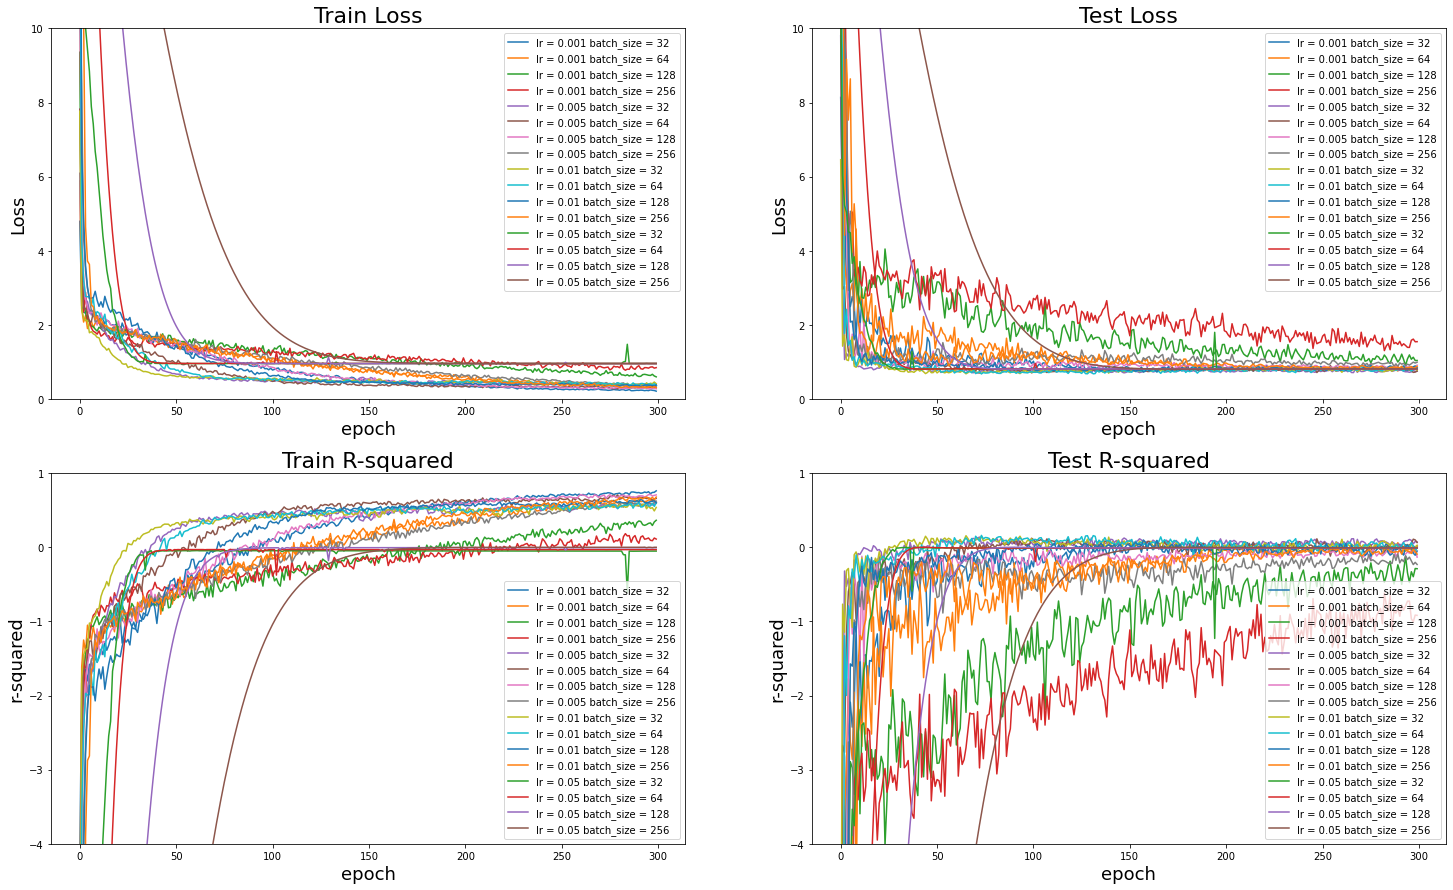

<Figure size 1800x1080 with 0 Axes>

In [13]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 10])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 10])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-4,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-4,1])

plt.show()

In [14]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.761504406529327
0.5979775848702429
0.36467978013355956
0.11084099353873218
0.6026794114672605
0.658672924389385
0.7066647990267871
0.623090526123163
0.5383947510121321
0.5973022102358836
0.6020403197034347
0.6776980068599275
-0.05105180284398696
-0.03146125514808421
-0.005372513159950243
-0.00047389602751737316
___________________

0.01629825929365203
0.016677547057471376
-0.2888687624990378
-0.9182499451793262
0.07154861044614491
0.0643512512677138
-0.13270652552130535
-0.23192562787708737
0.027962484909851648
-0.00969892625031532
-0.05095382401154791
-0.09192625896007334
-0.007397895038037783
-0.010342052766919352
-0.009188674224772209
-0.008442831002137607
___________________

0.21250258061366203
0.37249948382377623
0.5984402358531952
0.8475627303123474
0.35545048614343006
0.31453065276145936
0.27653634995222093
0.35788880586624144
0.4129958282678555
0.3722679853439331
0.3795804888010025
0.3073203206062317
0.9607575214826144
0.9603022634983063
0.956154727935791
0.9545515775680542


### 2 best models

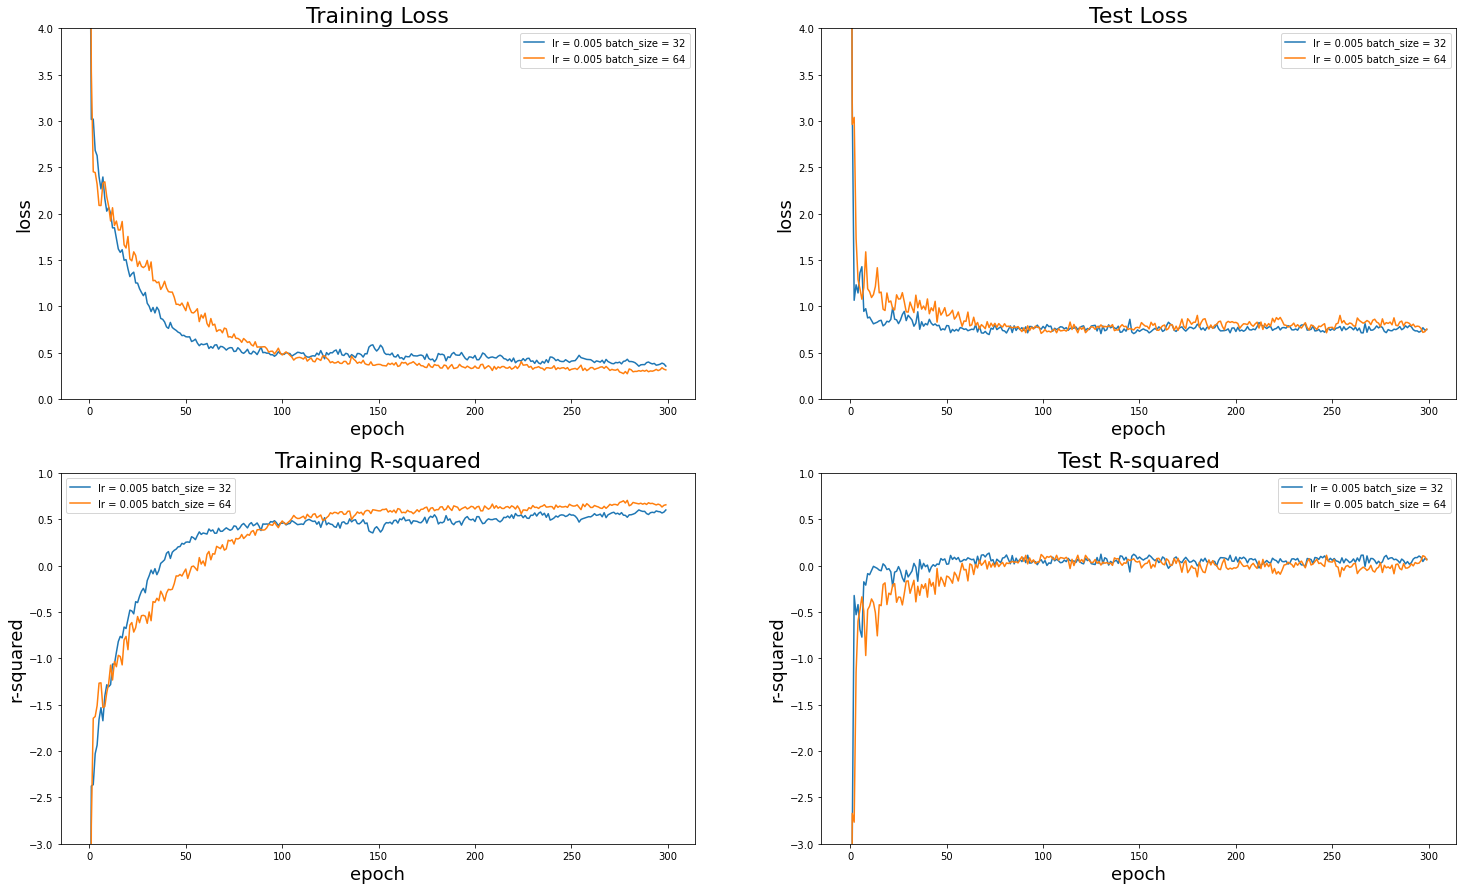

<Figure size 432x288 with 0 Axes>

In [16]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[4],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[5],label="lr = 0.005 batch_size = 64")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 4])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[4],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[5],label="lr = 0.005 batch_size = 64")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 4])

ax3.set_title("Training R-squared", fontsize=22)
ax3.plot(train_accs_all[4],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[5],label="lr = 0.005 batch_size = 64")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-3,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[4],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[5],label="llr = 0.005 batch_size = 64")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-3,1])
plt.show()

## 4.2. Training

In [24]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=353, shuffle=False)

In [25]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.005)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/solub_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 5.695516077677409, Accuracy: -5.2877479955999425
Test Avg. loss: 6.739134788513184, Accuracy: -6.361905466786795
################## EPOCH 2 ##################
Train Avg. loss: 2.808808061811659, Accuracy: -2.1894184015127283
Test Avg. loss: 1.5609019994735718, Accuracy: -0.7051466542694258
################## EPOCH 3 ##################
Train Avg. loss: 2.6170847256978353, Accuracy: -1.9548807144072136
Test Avg. loss: 2.8188226222991943, Accuracy: -2.079313062093872
################## EPOCH 4 ##################
Train Avg. loss: 2.6881530973646375, Accuracy: -2.024316591565722
Test Avg. loss: 1.5366277694702148, Accuracy: -0.6786293469019347
################## EPOCH 5 ##################
Train Avg. loss: 2.485260550181071, Accuracy: -1.8199173054540236
Test Avg. loss: 1.1141027212142944, Accuracy: -0.2170582133862493
################## EPOCH 6 ##################
Train Avg. loss: 2.151726974381341, Accuracy: -1.4279193262946064


Train Avg. loss: 0.8351294133398268, Accuracy: 0.072093067388171
Test Avg. loss: 0.7394967675209045, Accuracy: 0.1921654888914277
################## EPOCH 48 ##################
Train Avg. loss: 0.7911051630973815, Accuracy: 0.10762531329808794
Test Avg. loss: 0.7144943475723267, Accuracy: 0.21947847078050886
################## EPOCH 49 ##################
Train Avg. loss: 0.7744332631429036, Accuracy: 0.14277390323997227
Test Avg. loss: 0.7266836166381836, Accuracy: 0.20616277551587825
################## EPOCH 50 ##################
Train Avg. loss: 0.7604872703552246, Accuracy: 0.1483099274882224
Test Avg. loss: 0.7130064368247986, Accuracy: 0.2211039058834493
################## EPOCH 51 ##################
Train Avg. loss: 0.7718704402446747, Accuracy: 0.1329526330111229
Test Avg. loss: 0.7130906581878662, Accuracy: 0.2210118734789136
################## EPOCH 52 ##################
Train Avg. loss: 0.738294302754932, Accuracy: 0.17592322421636247
Test Avg. loss: 0.6892462968826294, Accur

Train Avg. loss: 0.6432460986905628, Accuracy: 0.2801960076361139
Test Avg. loss: 0.7343077063560486, Accuracy: 0.19783410637461318
################## EPOCH 94 ##################
Train Avg. loss: 0.5732145554489559, Accuracy: 0.35533125456611464
Test Avg. loss: 0.7510412931442261, Accuracy: 0.17955415078964865
################## EPOCH 95 ##################
Train Avg. loss: 0.608234883679284, Accuracy: 0.31647192595279156
Test Avg. loss: 0.7120182514190674, Accuracy: 0.22218341432346134
################## EPOCH 96 ##################
Train Avg. loss: 0.5963707076178657, Accuracy: 0.3265105076633297
Test Avg. loss: 0.6963076591491699, Accuracy: 0.2393458166330572
################## EPOCH 97 ##################
Train Avg. loss: 0.6033452762497796, Accuracy: 0.3251837384036603
Test Avg. loss: 0.7175439596176147, Accuracy: 0.2161470214522908
################## EPOCH 98 ##################
Train Avg. loss: 0.6358561370107862, Accuracy: 0.2964116969815909
Test Avg. loss: 0.7158095240592957, Accu

Train Avg. loss: 0.544918378856447, Accuracy: 0.39320807022241816
Test Avg. loss: 0.7124642133712769, Accuracy: 0.22169622409269862
################## EPOCH 140 ##################
Train Avg. loss: 0.5667313853899638, Accuracy: 0.3666766088374391
Test Avg. loss: 0.7479486465454102, Accuracy: 0.18293262149362077
################## EPOCH 141 ##################
Train Avg. loss: 0.5343370722399817, Accuracy: 0.39839827889062496
Test Avg. loss: 0.7336351275444031, Accuracy: 0.198568843733252
################## EPOCH 142 ##################
Train Avg. loss: 0.6466265343957477, Accuracy: 0.28441412409063765
Test Avg. loss: 0.72735995054245, Accuracy: 0.20542399480726925
################## EPOCH 143 ##################
Train Avg. loss: 0.5742803586853875, Accuracy: 0.3590119417818428
Test Avg. loss: 0.7170774936676025, Accuracy: 0.21665660431990508
################## EPOCH 144 ##################
Train Avg. loss: 0.6149130781491597, Accuracy: 0.3135580662338511
Test Avg. loss: 0.6910377740859985, 

Train Avg. loss: 0.49799034496148425, Accuracy: 0.4367532401806137
Test Avg. loss: 0.731306791305542, Accuracy: 0.20111234490601615
################## EPOCH 186 ##################
Train Avg. loss: 0.5360813425646888, Accuracy: 0.3944087790817893
Test Avg. loss: 0.7242847084999084, Accuracy: 0.2087833558042823
################## EPOCH 187 ##################
Train Avg. loss: 0.5231888039244545, Accuracy: 0.4072926799475531
Test Avg. loss: 0.7018752098083496, Accuracy: 0.23326371849509586
################## EPOCH 188 ##################
Train Avg. loss: 0.5207804196410709, Accuracy: 0.41224618109088856
Test Avg. loss: 0.7046108245849609, Accuracy: 0.2302752820211562
################## EPOCH 189 ##################
Train Avg. loss: 0.504293918940756, Accuracy: 0.4258825647951733
Test Avg. loss: 0.6811881065368652, Accuracy: 0.2558625730188634
################## EPOCH 190 ##################
Train Avg. loss: 0.5127618067794376, Accuracy: 0.4231743060360232
Test Avg. loss: 0.7415163516998291, A

Train Avg. loss: 0.5331748270326191, Accuracy: 0.40073295735852604
Test Avg. loss: 0.7307820320129395, Accuracy: 0.20168560686703318
################## EPOCH 232 ##################
Train Avg. loss: 0.5090829983146654, Accuracy: 0.4275987870809605
Test Avg. loss: 0.7547007203102112, Accuracy: 0.1755565147201058
################## EPOCH 233 ##################
Train Avg. loss: 0.49517086574600805, Accuracy: 0.4431911428452979
Test Avg. loss: 0.737732470035553, Accuracy: 0.19409298368187378
################## EPOCH 234 ##################
Train Avg. loss: 0.531684229729904, Accuracy: 0.3944173064833018
Test Avg. loss: 0.7274050712585449, Accuracy: 0.20537472896626896
################## EPOCH 235 ##################
Train Avg. loss: 0.5316451509793599, Accuracy: 0.3994062377445753
Test Avg. loss: 0.7036650776863098, Accuracy: 0.23130852153852266
################## EPOCH 236 ##################
Train Avg. loss: 0.46777254955636133, Accuracy: 0.4656389884506909
Test Avg. loss: 0.6973589658737183

Train Avg. loss: 0.5341329918967352, Accuracy: 0.4033746086606138
Test Avg. loss: 0.710722804069519, Accuracy: 0.22359849447326918
################## EPOCH 278 ##################
Train Avg. loss: 0.46934601068496706, Accuracy: 0.47236130838712614
Test Avg. loss: 0.7263693809509277, Accuracy: 0.20650599917492418
################## EPOCH 279 ##################
Train Avg. loss: 0.4575525199373563, Accuracy: 0.47744128193028346
Test Avg. loss: 0.7264425158500671, Accuracy: 0.20642620709384452
################## EPOCH 280 ##################
Train Avg. loss: 0.48779718279838563, Accuracy: 0.45125796256008954
Test Avg. loss: 0.7150042653083801, Accuracy: 0.21892136657068484
################## EPOCH 281 ##################
Train Avg. loss: 0.4780494816601276, Accuracy: 0.46532751774186487
Test Avg. loss: 0.6862000226974487, Accuracy: 0.25038751841104223
################## EPOCH 282 ##################
Train Avg. loss: 0.4742042700967027, Accuracy: 0.46372580248494494
Test Avg. loss: 0.7491587996

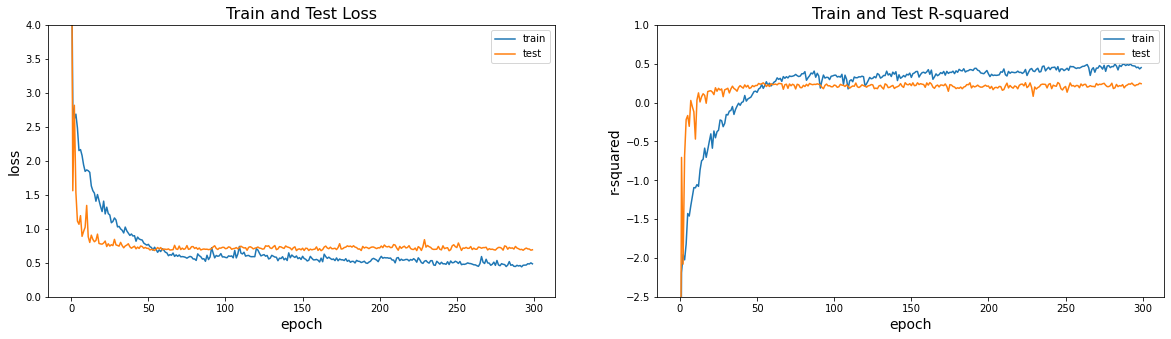

<Figure size 1440x360 with 0 Axes>

In [29]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0,4])
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.set_ylim([-2.5,1])
ax2.legend()
plt.show()

In [30]:
model = FCNN()
model.load_state_dict(torch.load('../../models/solub_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.6756956
MSE: 0.6779315
RMSE: 0.8233659
R2 Square 0.25942013297117794 

